# Desafío Agtech 2020 - Trabajo Final Computer Vision II

## Descripción del desafío
La agricultura tiene una importancia estratégica en la economía argentina, siendo uno de los países líderes en el mercado mundial de granos, su potencial productivo se manifiesta tanto en la producción primaria como en la agroindustria. Por lo anterior, es importante determinar qué cultivos se están sembrando, no solo para la optimización de políticas públicas y privadas en materia de inversión de recursos económicos, sino también para entender el impacto que estas decisiones tienen, y nuestra responsabilidad, en el cuidado del ambiente. Uno de los insumos fundamentales para estimar la cosecha consiste en salidas a campo, donde a través de la inspección ocular, se registra el tipo de cultivo hallado en cada parcela. Posteriormente, esta verdad de campo se utiliza en conjunto con imágenes satelitales para extrapolar el tipo de dato a otras parcelas empleando diversas técnicas de aprendizaje automático.

Debido a la pandemia del COVID-19 las salidas a campo para la obtención de esta información se han visto afectadas, lo cual presenta una gran oportunidad para desarrollar algoritmos que, usando inteligencia artificial en imágenes satelitales, logren clasificar los diversos cultivos en Argentina.

Contar con un método confiable de clasificación remota de cultivos es fundamental en países como Argentina, donde la extensión geográfica dificulta cubrir todas las zonas de interés de modo presencial, por lo cual, la relevancia del desarrollo de estas estas tecnologías se mantiene en campañas futuras, no solo bajo condiciones especiales de pandemia.

Es aquí donde se une la Agricultura con la Tecnología y da nacimiento el término AgTech.

* Objetivo: Los participantes deberán construir un método de aprendizaje supervisado que mediante imágenes satelitales y la verdad de campo de cosechas previas pueda clasificar cultivos para distintos puntos geográficos del departamento de General López, Santa Fé.

* Oportunidad para los participantes: Los participantes tendrán la oportunidad de trabajar con la verdad de campo de cosechas previas que ha sido recolectada por la Bolsa de Comercio de Rosario y por la Bolsa de Cereales de Buenos Aires, y que será abierta de forma exclusiva para esta concurso. Además, se brindarán capacitaciones sobre cómo trabajar con imágenes satelitales para llevar adelante esta y otro tipo de tareas.


## Abordaje del Problema
Como dataset inicial se brinda una lista de observaciones sobre distintos campos conocidas como "verdad de campo". Se entiende por este término a la información obtenida por las Bolsas, quienes todos los años se encargan de realizar salidas a campo para determinar, mediante la inspección ocular, cuáles son los cultivos que están siendo sembrados en los distintos lotes. 
La identificación de los lotes se da a través de la latitud y longitud de los mismos, es por ello que la competencia sugiere el uso de satelites para la obtención de imágenes.
Se dividió al problema en distintas etapas para su correcta resolución y propiciando el trabajo ordenado del equipo:

* Colab Setup: se monta el Drive, se autentifica la cuenta de Google Earth Engine, se importan los archivos necesarios desde GitHub, se descargan e importan las librerías necesarias y se describen funciones útiles para el resto del documento.
* Tabular dataset: se analizan y se visualizan los datos tabulares dados como train_set y test_set por los organizadores de la competencia.
* Image dataset: se descargan o importan las imágenes ya descargadas asociadas a las coordenadas dadas por los datos tabulares. Se llevan a cabo procesos de preprocesamiento, data augmentation y generación de nuevas features.
* Model Selection: se generan modelos de diversas naturalezas, se entrenan y posteriormente se los usa para realizar predicciones y generar el archivo para subir a la página de la competencia
* Conclusiones y posibles próximos pasos

## Colab setup

### Autenthifications

Montamos el Drive y autorizamos el acceso a Google Earth Engine

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=5N5V41aLH2ov_Pob4cDiqHLe-DtcELCmukMMVZ6VJcQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5J0F_Iaf9mS0XaR72B1TOddsKZcpYdid6GQ6d2GdE1xmzGLpX3PR0

Successfully saved authorization token.


### Libraries

Descarga de librerias

In [ ]:
%%capture
% pip install geehydro geopandas geextract geemap gdal sentinelhub tiffile

Importamos algunas de las librerías usadas, el resto se importan a lo largo del documento:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime
import tifffile as t
import math
import folium
import geehydro
import geopandas as gpd
from sklearn import ensemble, linear_model, svm

Ya que el Colab justamente no permite el trabajo colaborativo simultáneo y con el objetivo de poder entrenar los algoritmos cada uno, generamos todos los path referidos a un 'root_path'. De esta forma con sólo actualizar el valor de esa variable cada uno de los integrantes del grupo podía correr el código y acceder tanto a la información como a las imágenes ya descargadas (localizadas en un Drive).

In [ ]:
#ALFON '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/CV2/DesafíoAgtech2020/'
#JULI '/content/drive/MyDrive/02_Especialización_IA/08_computer_vision_2/'
#NICO '/content/drive/MyDrive/EspecialazacionIA/Bimestre3/CV2/DesafioAgtech'

root_path = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/CV2/DesafíoAgtech2020/'

image_folder= 'Imagenes_Agrotech'
downloadPath = root_path + image_folder
test_dir = root_path + image_folder + '/Test'
train_dir = root_path + image_folder + '/Train'
val_dir = root_path + image_folder + '/Validation'

test_dir_set2 = root_path + image_folder + '/Test_set2'
train_dir_set2 = root_path + image_folder + '/Train_set2'
val_dir_set2 = root_path + image_folder + '/Validation_set2'


Realizamos un fork del repositorio de la competencia a uno de nuestros GitHub y luego exportamos los datos directamente desde ahí:

In [ ]:
git_path = 'https://raw.githubusercontent.com/AlfonsoRafel/DesafioAgTech2020/master/dataset/'
!git clone https://github.com/AlfonsoRafel/DesafioAgTech2020.git
!unrar -o+ x DesafioAgTech2020/dataset/Gral_Lopez.rar DesafioAgTech2020/dataset/

train_data = pd.read_csv(git_path + 'data_train.csv', error_bad_lines=False)
label_data = pd.read_csv(git_path + 'Etiquetas.csv', error_bad_lines=False)

test_data = pd.read_csv(git_path + 'data_test.csv', error_bad_lines=False)

Cloning into 'DesafioAgTech2020'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from DesafioAgTech2020/dataset/Gral_Lopez.rar

Extracting  DesafioAgTech2020/dataset/Gral Lopez.shx                       3%  OK 
Extracting  DesafioAgTech2020/dataset/Gral Lopez.cpg                       5%  OK 
Extracting  DesafioAgTech2020/dataset/Gral Lopez.dbf                      17%  OK 
Extracting  DesafioAgTech2020/dataset/Gral Lopez.prj                      24%  OK 
Extracting  DesafioAgTech2020/dataset/Gral Lopez.qpj                      31%  OK 
Extracting  DesafioAgTech2020/dataset/Gral Lopez.shp                      98%  OK 
All OK


### Funciones Utiles

Este apartado tiene como objetivo facilitar la lectura y ejecución del código, se incluyen las funciones que serán utilizadas en diversas partes del colab. De esta manera, al ejecutar esta sección, uno puede estar seguro de que las funciones utilizadas en el código serán reconocidas.

Dentro de cada función se inlcuyó una breve descripción de su propósito, input y optput.

In [ ]:
def plot_history(model_history):
    """ 
  Graphs the evolution of loss and 'categorical_accuracy' metrics over the ages in model_history training

   INPUT: 
   - model_history: Keras' object that contains the information about the evolution of the model along the epochs 

   OUTPUT:
   - NotImplemented

   """

  train_accuracy = model_history.history['categorical_accuracy']
  train_loss = model_history.history['loss']

  fig, (a1, a2) = plt.subplots(1,2, figsize=(20,10))

  a1.set_title('Accuracy evolution', fontsize=20)
  a1.plot(train_accuracy, label='Train_accuracy')
  a1.legend()

  a2.set_title('Loss evolution', fontsize=20)
  a2.plot(train_loss, label='Train_loss')
  a2.legend()

  plt.show()

  return

def preprocessing_image_ms(x, mean, std):
      """ 
   It pre-processes the image so that the channel values are centered at 0 and have a 1 offset.

   INPUT: 
   - x: Numpy array of the image
   - std: Numpy array with image channel offsets
   - mean: Numpy array with the average of the image channels

   OUTPUT:
   - x: numpy array from to image centered on 0 and offset 1
   """
    # loop over image channels
    for idx, mean_value in enumerate(mean):
        x[..., idx] -= mean_value
        x[..., idx] /= std[idx]
    return x


def categorical_label_from_full_file_name(files, class_indices):
        """ 
   Takes the names and categories of images from the file names and outputs a one_hot_encoding with output features

   INPUT:
   - files: image path
   - class_indices: dictionary with the classes to predict

   OUTPUT:
   - y: one_hot_encoding the image 

   """
    from keras.utils import to_categorical
    import os
    # file basename without extension
    base_name = [os.path.splitext(os.path.basename(i))[0] for i in files]
    # class label from filename
    base_name = [i.split("_")[0] for i in base_name]
    # label to indices
    image_class = [class_indices[i] for i in base_name]
    # class indices to one-hot-label
    return to_categorical(image_class, num_classes=len(class_indices))

def hyperspectral_image_generator(files, files2, class_indices, batch_size=32, image_mean=None,
                           rotation_range=0, shear_range=0, scale_range=1,
                           transform_range=0, horizontal_flip=False,
                           vertical_flip=False, crop=False, crop_size=None, filling_mode='edge',
                           speckle_noise=None):
  
   """ 
 Augmented multi-channel image pair generator. 
   """
  
    from skimage.io import imread
    import numpy as np
    from random import sample

    while True:

        indices = np.arange(len(files)).tolist()
        # select batch_size number of samples without replacement
        batch_indices = sample(indices, batch_size)

        batch_files = files[batch_indices]
        batch_files2 = files2[batch_indices]

        # get one_hot_label
        batch_Y = categorical_label_from_full_file_name(batch_files,
                                                        class_indices)
        # array for images
        batch_X = []
        batch_X2 = []
        # loop over images of the current batch
        for idx, input_path in enumerate(batch_files):
            image = np.array(imread(input_path), dtype=float)
            if image_mean is not None:
                mean_std_data = np.loadtxt(image_mean, delimiter=',')
                image = preprocessing_image_ms(image, mean_std_data[0], mean_std_data[1])
            # process image
            image = augmentation_image_ms(image, rotation_range=rotation_range, shear_range=shear_range,
                                          scale_range=scale_range,
                                          transform_range=transform_range, horizontal_flip=horizontal_flip,
                                          vertical_flip=vertical_flip, warp_mode=filling_mode)
            batch_X += [image]
            
        # Loop second image
        for idx, input_path in enumerate(batch_files2):
          image2 = np.array(imread(input_path), dtype=float)
          if image_mean is not None:
              mean_std_data = np.loadtxt(image_mean, delimiter=',')
              image2 = preprocessing_image_ms(image2, mean_std_data[0], mean_std_data[1])
          # process image
          image2 = augmentation_image_ms(image2, rotation_range=rotation_range, shear_range=shear_range,
                                        scale_range=scale_range,
                                        transform_range=transform_range, horizontal_flip=horizontal_flip,
                                        vertical_flip=vertical_flip, warp_mode=filling_mode)

          batch_X2 += [image2]
        
        # convert lists to np.array
        X = np.array(batch_X)
        X2 = np.array(batch_X2)
        Y = np.array(batch_Y)

        yield X, X2, Y
  
def augmentation_image_ms(image, rotation_range=0, shear_range=0, scale_range=1, transform_range=0,
                          horizontal_flip=False, vertical_flip=False, warp_mode='edge'):
  
  """ 
   Function that takes a numpy array of an image and outputs the image augmented with the specified parameters
   """
    from skimage.transform import AffineTransform, SimilarityTransform, warp
    from numpy import deg2rad, flipud, fliplr
    from numpy.random import uniform, random_integers
    from random import choice

    image_shape = image.shape
    # Generate image transformation parameters
    rotation_angle = uniform(low=-abs(rotation_range), high=abs(rotation_range))
    shear_angle = uniform(low=-abs(shear_range), high=abs(shear_range))
    scale_value = uniform(low=abs(1 / scale_range), high=abs(scale_range))
    translation_values = (random_integers(-abs(transform_range), abs(transform_range)),
                          random_integers(-abs(transform_range), abs(transform_range)))

    # Horizontal and vertical flips
    if horizontal_flip:
        # randomly flip image up/down
        if choice([True, False]):
            image = flipud(image)
    if vertical_flip:
        # randomly flip image left/right
        if choice([True, False]):
            image = fliplr(image)

    # Generate transformation object
    transform_toorigin = SimilarityTransform(scale=(1, 1), rotation=0, translation=(-image_shape[0], -image_shape[1]))
    transform_revert = SimilarityTransform(scale=(1, 1), rotation=0, translation=(image_shape[0], image_shape[1]))
    transform = AffineTransform(scale=(scale_value, scale_value), rotation=deg2rad(rotation_angle),
                                shear=deg2rad(shear_angle), translation=translation_values)
    # Apply transform
    image = warp(image, ((transform_toorigin) + transform) + transform_revert, mode=warp_mode, preserve_range=True)
    return image


def crop_image(image, target_size):
    from numpy import ceil, floor
    x_crop = min(image.shape[0], target_size[0])
    y_crop = min(image.shape[1], target_size[1])
    midpoint = [ceil(image.shape[0] / 2), ceil(image.shape[1] / 2)]

    out_img = image[int(midpoint[0] - ceil(x_crop / 2)):int(midpoint[0] + floor(x_crop / 2)),
              int(midpoint[1] - ceil(y_crop / 2)):int(midpoint[1] + floor(y_crop / 2)),
              :]
    assert list(out_img.shape[0:2]) == target_size
    return out_img


In [ ]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)



def deg2rad(degrees):
  """
  degrees to radians
  """
  return math.pi*degrees/180.0

# radians to degrees
def rad2deg(radians):
    """
  radians to degrees
  """
  return 180.0 * radians/math.pi
# Semi-axes of WGS-84 geoidal reference
WGS84_a = 6378137.0  # Major semiaxis [m]
WGS84_b = 6356752.3  # Minor semiaxis [m]

# Earth radius at a given latitude, according to the WGS-84 ellipsoid [m]
def WGS84EarthRadius(lat):
    # http://en.wikipedia.org/wiki/Earth_radius
    An = WGS84_a*WGS84_a * math.cos(lat)
    Bn = WGS84_b*WGS84_b * math.sin(lat)
    Ad = WGS84_a * math.cos(lat)
    Bd = WGS84_b * math.sin(lat)
    return math.sqrt( (An*An + Bn*Bn)/(Ad*Ad + Bd*Bd) )


def boundingBox(latitudeInDegrees, longitudeInDegrees, halfSideInMeters):
    lat = deg2rad(latitudeInDegrees)
    lon = deg2rad(longitudeInDegrees)
    halfSide = halfSideInMeters

    # Radius of Earth at given latitude
    radius = WGS84EarthRadius(lat)
    # Radius of the parallel at given latitude
    pradius = radius*math.cos(lat)

    latMin = lat - halfSide/radius
    latMax = lat + halfSide/radius
    lonMin = lon - halfSide/pradius
    lonMax = lon + halfSide/pradius

    return (rad2deg(latMin), rad2deg(lonMin), rad2deg(latMax), rad2deg(lonMax))

In [ ]:
def plot_map(test_data, train_data, ext=".shp"):
  long0 = min(test_data['Longitud'].min(), train_data['Longitud'].min() )
  long1 = max(test_data['Longitud'].max(), train_data['Longitud'].max() )
  lat0 = min(test_data['Latitud'].min(), train_data['Latitud'].min() )
  lat1 = max(test_data['Latitud'].max(), train_data['Latitud'].max() )
  lat = (lat0+lat1)/2
  lon = (long0+long1)/2
  boundary_ungs = ee.Geometry.Rectangle([long0, lat0, long1, lat1])
  map = folium.Map(location=[lat,lon], zoom_start=9)
  map.setOptions('HYBRID') # SATELLITE
  gdf = gpd.read_file("DesafioAgTech2020/dataset/Gral Lopez" + ext)
  gdf.to_file("region.geojson", driver='GeoJSON')
  folium.GeoJson( "region.geojson").add_to(map)
  marker_labels= {
    "S": [ "Soja", "red"],
    "M": [ "Maiz", "yellow"],
    "N": [ "Campo Natural", "green"],
    "A": [ "Agua", "lightblue"]
  }
  for k,v in marker_labels.items():
    for x in train_data[train_data.Cultivo == k][['Longitud','Latitud']].iterrows():
      crop_long = x[1][0]
      crop_lat = x[1][1]
      folium.CircleMarker( location=[crop_lat, crop_long], radius=10, 
                        line_color='black',fill_color=v[1], 
                        fill_opacity=0.5,popup="<i>%s</i>" % v[0] ).add_to(map)
  map.add_child(folium.LatLngPopup())
  map.add_child(folium.LayerControl())
  return map
  

## Tabular Dataset

### Data Analysis

Hay un total de **14 Clases** de imágenes identificadas en el dataset provisto por los organizadores. 

Puede verse en la distribución del estilo Paretto, donde en solamente las primeras 5 clases ~ 33% de las clases (Soja 1, Maiz Temprano, Soja 2, campo natural y Pasturas)  representan ~85% de los casos. 

Este un dataset muy desbalanceado y significará un desafío construir un clasificador que logre tener una buena performance con la métrica de Balanced Accuracy propuesta en la competencia.


In [ ]:
train_data.head()

,Id,Cultivo,Longitud,Latitud,Elevacion,Dataset,Campania,GlobalId
0,1,S,-62.144163,-33.800202,104.111862,BC,18/19,1
1,4,M,-62.155418,-33.801742,105.698082,BC,18/19,4
2,6,N,-62.163615,-33.808092,104.233162,BC,18/19,6
3,7,M,-62.164773,-33.813671,103.859932,BC,18/19,7
4,9,M,-62.097200,-33.778628,98.532104,BC,18/19,9


In [ ]:
label_data.head()

,CultivoId,Cultivo,Tipo
0,1,S,SOJA 1
1,2,s,SOJA 2
2,3,M,MAIZ TEMP
3,4,m,MAIZ TARD O 2DA
4,5,T,TRIGO


<Figure size 720x360 with 0 Axes>

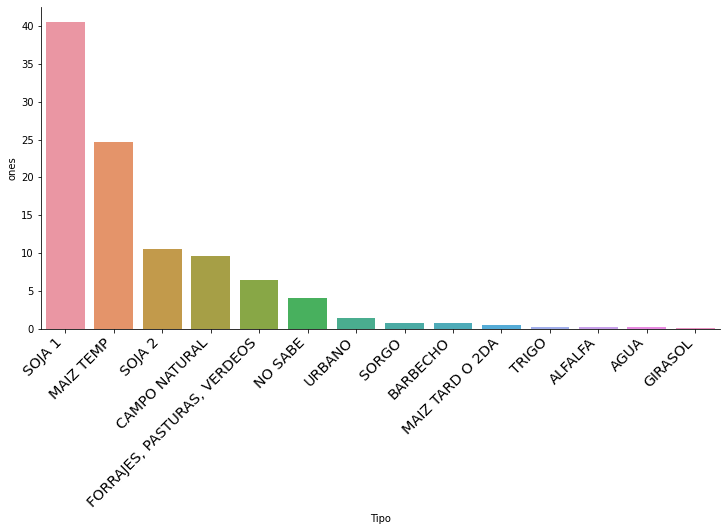

In [ ]:
def data_merge(dataset, label):
  dataset = dataset.merge(label, how='left')
  #print('Tamaño train set:', train_data.shape )
  #print('Tamaño merge set:', merge.shape )
  return dataset

def cat_hist(dataset):
  dataset['ones'] = np.ones(shape=(dataset.shape[0],1))
  plot_order = dataset.groupby('Tipo')['ones'].sum().sort_values(ascending=False).index.values
  plt.figure(figsize=(10,5))
  chart = sns.catplot(x='Tipo', y='ones', data = dataset, kind='bar', 
                    estimator=lambda x: len(x) / len(dataset) * 100, order = plot_order, aspect=2)
  plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large')


dataset = data_merge(train_data, label_data)
cat_hist(dataset)

Se utiliza el método One Hot Encoding sobre las variables categóricas, para obtener todas variables numéricas y poder realizar un análisis de correlación con la salida (CultivoId). La finalidad de este análisis es encontrar relaciones lineales entre features y salida, de manera de entender que información de contexto dada por los datos tabulares podría ser útil para incluir en el modelo.

In [ ]:
# One hot encoding:
data_categorical = dataset[['Dataset', 'Campania']]
dummies = pd.get_dummies(data=data_categorical, columns=data_categorical.columns)
data_not_categorical = dataset.drop(['Dataset', 'Campania'], axis=1, inplace=False)
data_reg_full = pd.concat([data_not_categorical, dummies], axis=1)
print('Tamaño del dataset de numérico: {}'.format(data_not_categorical.shape))
print('Tamaño del dataset de dummies: {}'.format(dummies.shape))
print('Tamaño del dataset con one hot encoding: {}'.format(data_reg_full.shape))

Tamaño del dataset de numérico: (850, 9)
Tamaño del dataset de dummies: (850, 4)
Tamaño del dataset con one hot encoding: (850, 13)


In [ ]:
dataset.corr()

,Id,Longitud,Latitud,Elevacion,GlobalId,CultivoId,ones
Id,1.000000,0.403187,-0.152613,-0.355093,0.243415,-0.055779,NaN
Longitud,0.403187,1.000000,0.602195,-0.481853,0.076120,0.009835,NaN
Latitud,-0.152613,0.602195,1.000000,-0.154140,-0.271859,0.013143,NaN
Elevacion,-0.355093,-0.481853,-0.154140,1.000000,-0.169682,-0.251354,NaN
GlobalId,0.243415,0.076120,-0.271859,-0.169682,1.000000,0.035996,NaN
CultivoId,-0.055779,0.009835,0.013143,-0.251354,0.035996,1.000000,NaN
ones,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se observa una correlación lineal entre el Id de Cultivo y la elevación del campo, no así entre el Id y la Latitud y Longitud (localización del campo). Tanto el origen de la verdad de campo (Dataset) como la Campaña parecieran no influir en el valor de la salida. 

In [ ]:
data_reg_full.corr()

,Id,Longitud,Latitud,Elevacion,GlobalId,CultivoId,ones,Dataset_BC,Dataset_BCR,Campania_18/19,Campania_19/20
Id,1.000000,0.403187,-0.152613,-0.355093,0.243415,-0.055779,NaN,0.011744,-0.011744,0.153734,-0.153734
Longitud,0.403187,1.000000,0.602195,-0.481853,0.076120,0.009835,NaN,0.118871,-0.118871,0.007889,-0.007889
Latitud,-0.152613,0.602195,1.000000,-0.154140,-0.271859,0.013143,NaN,0.286051,-0.286051,0.126412,-0.126412
Elevacion,-0.355093,-0.481853,-0.154140,1.000000,-0.169682,-0.251354,NaN,-0.002480,0.002480,0.077105,-0.077105
GlobalId,0.243415,0.076120,-0.271859,-0.169682,1.000000,0.035996,NaN,-0.812134,0.812134,-0.828248,0.828248
CultivoId,-0.055779,0.009835,0.013143,-0.251354,0.035996,1.000000,NaN,0.020293,-0.020293,-0.104240,0.104240
ones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dataset_BC,0.011744,0.118871,0.286051,-0.002480,-0.812134,0.020293,NaN,1.000000,-1.000000,0.521920,-0.521920
Dataset_BCR,-0.011744,-0.118871,-0.286051,0.002480,0.812134,-0.020293,NaN,-1.000000,1.000000,-0.521920,0.521920
Campania_18/19,0.153734,0.007889,0.126412,0.077105,-0.828248,-0.104240,NaN,0.521920,-0.521920,1.000000,-1.000000


In [ ]:
corr_matrix = data_reg_full.corr()
corr_matrix['CultivoId'].sort_values(ascending=False)

CultivoId         1.000000
Campania_19/20    0.104240
GlobalId          0.035996
Dataset_BC        0.020293
Latitud           0.013143
Longitud          0.009835
Dataset_BCR      -0.020293
Id               -0.055779
Campania_18/19   -0.104240
Elevacion        -0.251354
ones                   NaN
Name: CultivoId, dtype: float64

### Data Visualization

Mediante la visualización observamos que las verdades de campo fueron obtenidas a través de la observación de los mismos y un posterior cálculo del centro de localización de cada terreno. La gran mayoría de los terrenos relevados son adyacentes a rutas/caminos, limitandonos entonces la dimensión de campo que podremos considerar al momento de recolectar imágenes desde el satélite. Algunos puntos incluso corresponden al mismo campo, por lo que podría considerarse una distancia mínima para diferenciar dos terrenos.

In [ ]:
plot_map(test_data, train_data, ".dbf")

## Image Dataset

Sentinel-2 es una misión de observación de la Tierra del Programa Copérnico que adquiere sistemáticamente imágenes ópticas de alta resolución espacial sobre tierra y aguas costeras. La misión es una constelación con dos satélites gemelos, Sentinel-2A y Sentinel-2B. La misión presta apoyo a una amplia gama de servicios y aplicaciones, como la vigilancia agrícola, la gestión de emergencias, la clasificación de la cubierta terrestre o la calidad del agua. Por esta razón, Sentinel-2 fue elegido como satélite a utilizar en este trabajo.


Sentinel 2 arroja imágenes satelitales de 14 bandas, las cuales se describen a continuación:


Band	- Resolution -	Central - Wavelength -	Description
1.   B1	- 60 m	- 443 nm -	Ultra blue (Coastal and Aerosol)
2.   B2 -	10 m -	490 nm -	Blue
3.   B3 -	10 m -	560 nm -	Green
4.   B4 -	10 m -	665 nm -	Red
5.   B5 -	20 m -	705 nm -	Visible and Near Infrared (VNIR)
6. B6 -	20 m -	740 nm -	Visible and Near Infrared (VNIR)
7. B7 -	20 m - 783 nm -	Visible and Near Infrared (VNIR)
8. B8 -	10 m -	842 nm -	Visible and Near Infrared (VNIR)
9. B8a -	20 m -	865 nm -	Visible and Near Infrared (VNIR)
10. B9 -	60 m -	940 nm -	Short Wave Infrared (SWIR)
11. B10 -	60 m -	1375 nm -	Short Wave Infrared (SWIR)
12. B11 -	20 m -	1610 nm -	Short Wave Infrared (SWIR)
13. B12 -	20 m -	2190 nm -	Short Wave Infrared (SWIR)

También se puede combinar la información para arrojar nuevos indice, como el "Indicador de Humedad", el "NDVI" y otros.

en particular, se utilizarán:
-  Indice de Humedad (B8A-B11)/(B8A+B11)
- NDVI (B8-B4)/(B8+B4)

Las Bandas de interés serán entonces: 
- B2, B3, B4, B8a, B8, B11

https://gisgeography.com/sentinel-2-bands-combinations/

### Image Download

**Seleccíon de intervalos para descarga de imágenes satelitales**

Para realizar la clasificación de cultivos con imágenes satelitales, es menester hacer una selección adecuada de las fechas en las cuales se tomarán las imágenes del satélite. La fecha elegida tiene que cumplir con los siguientes requisitos:
- Representar el momento del año en el cuál las diferencias visuales entre los cultivos analizados son máximas.
- Tiene que concordar con un momento en el cuál una cantidad significativa de los cultivos analizados hayan sobrepasado el período de siembra
- Debe representar un momento donde una fracción de los cultivos analizados hayan pasado la fecha de cierre de zurco.

En este respecto, se consultó a ingenieros agrónomos, se analizaron las curvas de NDVI y las curvas de plantación acumulada. En éste análisis se determinó que no hay una fecha única que cumple con los requisitos antes mencionados. Además, siendo que se conoce la campaña pero no la estación, no es posible saber a priori si la observación fue en verano o invierno. Siendo que la gran mayoría de observaciones corresponden a cultivos de verano, se seleccionaron dos rangos de fechas para importar las imágenes: Fines de Diciembre y mediados de Enero.

Los intervalos elegidos serán entonces: 
- Desde 2018/19-12-15 hasta 2019/20-12-29  
- Desde 2019/20-01-07 hasta 2019/20-01-21  

**Descarga de imágenes satelitales**

Para descargar las imágenes satelitales se utilizó el servicio de SentinelHub, que disponibilizan una API que permite descargar las imágenes de una manera rápida y conveniente.

Las imagenes descargadas del satélite corresponden a regiones cuadrangulares de 100mtsx100mts con centro en la latitud y longitud provistas por los organizadores del Desafío AgTech.


In [ ]:
from sklearn.model_selection import train_test_split


print('Distribución de cultivos: \n\n' , train_data[['Cultivo']].astype('category').value_counts())

## Descarto todos los cultivos que tienen menos de 12 observaciones
## Descarto los cultivos clasificados como "NO SABE"
descarte = ['G', 'S/M', 'A', 'T', 'aa', 'm', 'B', 'R', 'U', 'X']

train_data = pd.read_csv(git_path + 'data_train.csv', error_bad_lines=False)
new_classes_data = train_data[train_data.Cultivo.isin(descarte)]
train_data = train_data[~train_data.Cultivo.isin(descarte)]


## Agregar la fecha en la cuál será recolectada la imagen del satelite

fecha_inicio_intervalo_campaña = {'18/19': '2019-01-07',
                              '19/20': '2020-01-07'}

fecha_fin_intervalo_campaña = {'18/19': '2019-01-21',
                              '19/20': '2020-01-21'}      


fecha_inicio_intervalo_campaña_2 = {'18/19': '2018-12-15',
                              '19/20': '2019-12-15'}

fecha_fin_intervalo_campaña_2 = {'18/19': '2018-12-29',
                              '19/20': '2019-12-29'}      

## Train
# train_data['imagenes_desde'] = train_data.Campania.map(fecha_inicio_intervalo_campaña)
# train_data['imagenes_hasta'] = train_data.Campania.map(fecha_fin_intervalo_campaña)

train_data['imagenes_desde'] = train_data.Campania.map(fecha_inicio_intervalo_campaña)
train_data['imagenes_hasta'] = train_data.Campania.map(fecha_fin_intervalo_campaña)

x = train_data.drop('Cultivo', axis=1)
y = train_data[['Cultivo']]

train_x, validation_x, train_y, validation_y = train_test_split(x, y, test_size=0.05, stratify=y, random_state=0)


## Nuevas CLASES

new_classes_data_img1 = new_classes_data
new_classes_data_img2 = new_classes_data

new_classes_data_img1['imagenes_desde'] = new_classes_data.Campania.map(fecha_inicio_intervalo_campaña)
new_classes_data_img1['imagenes_hasta'] = new_classes_data.Campania.map(fecha_fin_intervalo_campaña)

new_classes_data_img2['imagenes_desde'] = new_classes_data.Campania.map(fecha_inicio_intervalo_campaña_2)
new_classes_data_img2['imagenes_hasta'] = new_classes_data.Campania.map(fecha_fin_intervalo_campaña_2)


Distribución de cultivos: 

 Cultivo
S          344
M          210
s           89
N           82
P           55
dtype: int64


In [ ]:
## Inicio instancia de trabajo en Sentinel Hub

from sentinelhub import SHConfig

CLIENT_ID = 'f520aba4-4a62-4d19-bb95-013976b65cfe'
CLIENT_CREDENTIALS = 'e1dD;7Ugq5%1%Q4Csdg{~Fq}YJACM2ZI42SpXu+)'
INSTANCE_ID = 'ab4336ae-427f-4fc4-ad82-9fab0a2f2a55'

config = SHConfig()

if CLIENT_ID and CLIENT_CREDENTIALS:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_CREDENTIALS
    config.instance_id = INSTANCE_ID
else:
    config = None

In [ ]:
# Importo las imágenes

from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, DataCollection, bbox_to_dimensions

def create_boxes_with_latlon(data, radius_in_meters = 50):

  """ Función que toma latitudes y longitudes de los puntos geográficos a analizar y 
   devuelve BOUNDING BOXES CUADRADAS de cada uno de ellos de lado "radius in meters"
   
   INPUT: 
   - Lats: numpy array de latitudes
   - Lons: numpy array de longitudes
   - radius_in_meters: l/2 la longitud del lado de la bounding box

   """

  bbox_collection = []

  n_images = len(data)
  lats = data[['Latitud']]
  lons = data[['Longitud']]

  for i in range(n_images):

        lat = lats.iloc[i]
        lon = lons.iloc[i]

        geo_position_box = boundingBox(lat, lon, radius_in_meters)
        box_wgs84 = [geo_position_box[1], geo_position_box[0], geo_position_box[3], geo_position_box[2]]
        bbox_single = BBox(bbox=box_wgs84, crs=CRS.WGS84)

        bbox_collection.append(bbox_single)
  return bbox_collection

In [ ]:
def descargar_imagenes_sentinel(data, cultivos, downloadPath, radius_in_meters = 50):
  
  wms_imgs = []
  wms_img = []
  n_images = len(data)

  fecha_desde = data['imagenes_desde']
  fecha_hasta	= data['imagenes_hasta']

  bbox_collection = create_boxes_with_latlon(data, radius_in_meters)

  for i in range(n_images):
    wms_request = WcsRequest(
        data_collection=DataCollection.SENTINEL2_L1C,
        layer='BANDS-S2-L1C', # Devuelve las bandas [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]
        bbox=bbox_collection[i],
        time=(fecha_desde.iloc[i], fecha_hasta.iloc[i]),
        resx = '10m',
        resy = '10m',
        image_format=MimeType.TIFF,
        data_folder = '/content',
        config=config
    )

    wms_img = wms_request.get_data()[0] # me descargo todas las imagenes y tomo la que tiene menor cantidad de nubes
    wms_imgs.append(wms_img)

    fileName = data['GlobalId'].iloc[i]
    cultivo = cultivos.iloc[i].values[0]

    fullPath =os.path.join(downloadPath, cultivo) 
    if  not os.path.isdir(fullPath):
      os.makedirs(fullPath)

    filePath = os.path.join(fullPath, cultivo + '_' + str(fileName) + '.tif')
    print(filePath, wms_img.shape, wms_img.max())
    if wms_img.max() > 0:
      t.imwrite(filePath, wms_img, photometric='minisblack')
    else:
      print("No se pudo descargar imagen", fileName)

  print('There are %d Sentinel-2 images available' % len(wms_imgs))



def descargar_imagenes_sentinel_TEST(data, downloadPath, radius_in_meters = 50):
  
  wms_imgs = []
  wms_img = []
  n_images = len(data)

  fecha_desde = data['imagenes_desde']
  fecha_hasta	= data['imagenes_hasta']

  bbox_collection = create_boxes_with_latlon(data, radius_in_meters)

  for i in range(n_images):
    wms_request = WcsRequest(
        data_collection=DataCollection.SENTINEL2_L1C,
        layer='BANDS-S2-L1C', # Devuelve las bandas [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]
        bbox=bbox_collection[i],
        time=(fecha_desde.iloc[i], fecha_hasta.iloc[i]),
        resx = '10m',
        resy = '10m',
        image_format=MimeType.TIFF,
        data_folder = '/content',
        config=config
    )

    wms_img = wms_request.get_data()[0] # me descargo todas las imagenes y tomo la que tiene menor cantidad de nubes
    wms_imgs.append(wms_img)

    fileName = data['GlobalId'].iloc[i]

    fullPath =os.path.join(downloadPath) 

    filePath = os.path.join(fullPath, str(fileName) + '.tif')
    print(filePath, wms_img.shape, wms_img.max())
    if wms_img.max() > 0:
      t.imwrite(filePath, wms_img, photometric='minisblack')
    else:
      print("No se pudo descargar imagen", fileName)

  print('There are %d Sentinel-2 images available' % len(wms_imgs))

# downloadPath_validation = '/content/drive/MyDrive/02_Especialización_IA/08_computer_vision_2/Imagenes_Agrotech/Validation'
# descargar_imagenes_sentinel(validation_x, validation_y, downloadPath_validation)

In [ ]:
descargar_imagenes_sentinel(train_x, train_y, train_dir, radius_in_meters=100)

new_classes_data_img1.drop(150, inplace=True)

x = new_classes_data_img1.drop('Cultivo', axis=1)
y = new_classes_data_img1[['Cultivo']]

descargar_imagenes_sentinel(x, y, train_dir, radius_in_meters=100)

x = new_classes_data_img2.drop('Cultivo', axis=1)
y = new_classes_data_img2[['Cultivo']]

descargar_imagenes_sentinel(x, y, train_dir_set2, radius_in_meters=100)

In [ ]:
descargar_imagenes_sentinel(validation_x, validation_y, val_dir, radius_in_meters=100)

In [ ]:
## Test

test_data['imagenes_desde'] = test_data.Campania.map(fecha_inicio_intervalo_campaña_2)
test_data['imagenes_hasta'] = test_data.Campania.map(fecha_fin_intervalo_campaña_2)

x_test = test_data.drop('Cultivo', axis=1)

descargar_imagenes_sentinel_TEST(test_data, test_dir_set2, radius_in_meters=100)

In [ ]:
test_data = pd.read_csv(git_path + 'data_test.csv', error_bad_lines=False)

test_data['imagenes_desde'] = test_data.Campania.map(fecha_inicio_intervalo_campaña)
test_data['imagenes_hasta'] = test_data.Campania.map(fecha_fin_intervalo_campaña)

x_test = test_data.drop('Cultivo', axis=1)

descargar_imagenes_sentinel_TEST(test_data, test_dir, radius_in_meters=100)

### Image Augmentation

In [ ]:
from glob import glob

descarte = ['G', 'A', 'T', 'aa', 'm', 'B', 'R', 'U', 'X']

paths_img1 = []
paths_img2 = []
class_indices = encoder[encoder.Cultivo.isin(descarte)].set_index('Cultivo').to_dict()['CultivoId']

class_indices_PRUEBA = {d:i for i, d in enumerate(descarte)}

for cultivo in descarte:
  paths_img1.append(train_dir + '/'+ cultivo)
  paths_img2.append(train_dir_set2 + '/'+ cultivo)

image_files_1 = [glob(path + '/*.tif') for path in paths_img1]
image_files_2 = [glob(path + '/*.tif') for path in paths_img2]

image_files_1 = np.array([item for sublist in image_files_1 for item in sublist])
image_files_2 = np.array([item for sublist in image_files_2 for item in sublist])

In [ ]:
# Parametrización de data augmentation
augmentation_parameters = {'flip': True, 
                            'zoom': 1.7,
                            'shift': 0.1,
                            'rotation': 90.0,
                            'noising': None}

generator = hyperspectral_image_generator(image_files_1, image_files_2,  
                                          class_indices_PRUEBA, 
                                          batch_size=1,
                                          rotation_range=augmentation_parameters['rotation'],
                                          horizontal_flip=augmentation_parameters['flip'],
                                          vertical_flip=augmentation_parameters['flip'],
                                          speckle_noise=augmentation_parameters['noising'],
                                          scale_range=augmentation_parameters['zoom'],
                                          transform_range=augmentation_parameters['shift'])

In [ ]:
def get_key(val):
    for key, value in class_indices_PRUEBA.items():
         if val == value:
             return key

augmented_dir = root_path + image_folder + '/Augmented_img1'
augmented_dir2 = root_path + image_folder + '/Augmented_img2'

n_images = 600
classes_augmented = []
images_augmented_1 = []
images_augmented_2 = []

for i in range(300, n_images, 1):
  data = next(generator)
  fileName = i

  image_1 = data[0].reshape(20,20,14)
  image_2 = data[1].reshape(20,20,14)
  
  value = np.argmax(data[2])
  cultivo = get_key(value)

  images_augmented_1.append(image_1)
  images_augmented_2.append(image_2)
  classes_augmented.append(cultivo)
   
  fullPath =os.path.join(augmented_dir, cultivo) 
  if  not os.path.isdir(fullPath):
    os.makedirs(fullPath)

  filePath = os.path.join(fullPath, cultivo + '_' + str(fileName) + '.tif')
  print(filePath, image_1.shape, image_1.max())
  if image_1.max() > 0:
    t.imwrite(filePath, image_1, photometric='minisblack')

  
  fullPath =os.path.join(augmented_dir2, cultivo) 
  if  not os.path.isdir(fullPath):
    os.makedirs(fullPath)

  filePath = os.path.join(fullPath, cultivo + '_' + str(fileName) + '.tif')
  print(filePath, image_2.shape, image_2.max())
  if image_2.max() > 0:
    t.imwrite(filePath, image_2, photometric='minisblack')

### Image Import

Una vez descargadas las imágenes en el Drive se procedió a importarlas. Para la primera vez se utilizó 'flow_from_directory', posteriormente se grabó la data en archivos pickle de manera de levantar las imágenes en menor tiempo.

In [ ]:
import re

def NDVI(imagen):
  # Calcula el NDVI de cada pixel
  ndvi = (imagen[0,:,:,3]-imagen[0,:,:,2]) / (imagen[0,:,:,3] + imagen[0,:,:,2])
  return ndvi.reshape((1,20,20,1))

def SAVI(imagen,L=0.2):
  #Calcula el SAVI de cada pixel
  nir = imagen[0,:,:,3]
  red = imagen[0,:,:,4]
  savi = (1+L)* (nir - red)/(nir+red+L)
  return savi.reshape((1,20,20,1))

def indice_de_humedad(imagen):
  #Calcula el índice de humedad de cada pixel
  ih = (imagen[0,:,:,8]-imagen[0,:,:,10])/ (imagen[0,:,:,8]+imagen[0,:,:,11])
  return ih.reshape((1,20,20,1))

def flow_from_directory_to_array(dirPath):
  regEx = r'([a-zA-Z]+)_'
  regEx_id = r'(\d+).'

  images = np.zeros(shape=(1,20,20,7))
  metadata = np.zeros(shape=(28))
  cultivos = np.zeros(shape=(1))
  general_ids = np.zeros(shape=(1))

  for root, dirs, files in os.walk(dirPath):
    for name in files:
        file_name = os.path.join(root, name)
        image_array = t.imread(file_name)[None, :,:,:]
        means = image_array[0].transpose().reshape((14,400)).mean(axis=1)
        stddev = image_array[0].transpose().reshape((14,400)).std(axis=1)
        meta_append = np.concatenate((means,stddev))
        metadata = np.vstack([metadata,meta_append])

        image_array = np.append(image_array,NDVI(image_array),axis=3)
        image_array = np.append(image_array,SAVI(image_array),axis=3)
        image_array = np.append(image_array,indice_de_humedad(image_array),axis=3)
        images = np.vstack([images, image_array[:,:,:,[1,2,3,8,14,15,16]] ])

        cultivo = re.findall(regEx, name)[0]
        cultivos = np.append(cultivos, cultivo)

        general_id = re.findall(regEx_id, name)[0]
        general_ids = np.append(general_ids, general_id)

  cultivos = cultivos[1:]
  images = images[1:]
  meta = metadata[1:]
  general_ids = general_ids[1:]

  return images, cultivos, meta, general_ids

def flow_from_directory_to_array_TEST(dirPath):
  regEx = r'(\d+).'

  images = np.zeros(shape=(1, 20,20,7))
  metadata = np.zeros(shape=(28))
  general_ids = np.zeros(shape=(1))

  for root, dirs, files in os.walk(dirPath):
    for name in files:
        file_name = os.path.join(root, name)
        image_array = t.imread(file_name)[None, :,:,:]
        means = image_array[0].transpose().reshape((14,400)).mean(axis=1)
        stddev = image_array[0].transpose().reshape((14,400)).std(axis=1)
        meta_append = np.concatenate((means,stddev))
        metadata = np.vstack([metadata,meta_append])

        image_array = np.append(image_array,NDVI(image_array),axis=3)
        image_array = np.append(image_array,SAVI(image_array),axis=3)
        image_array = np.append(image_array,indice_de_humedad(image_array),axis=3)
        images = np.vstack([images, image_array[:,:,:,[1,2,3,8,14,15,16]] ])

        general_id = re.findall(regEx, name)[0]
        general_ids = np.append(general_ids, general_id)

  general_ids = general_ids[1:]
  images = images[1:]
  meta = metadata[1:]
  return images, general_ids, meta


def get_campaign(full_data, images_ids):

    mapping = {'19/20': 1, 
               '18/19':0}

    campanias = np.zeros(1)

    for i in range(len(images_ids)):
      campania = full_data[full_data.GlobalId == images_ids.astype('int')[i]].Campania.values
      campanias = np.append(campanias, campania)

    campanias = campanias[1:]

    campanias = np.array([mapping[campania] for campania in campanias])

    return campanias


In [ ]:
images_train, cultivos_train, meta_train, ids_train = flow_from_directory_to_array(train_dir)
images_val, cultivos_val, meta_val, ids_val = flow_from_directory_to_array(val_dir)

images_train_set2, cultivos_train_set2, meta_train_set2, ids_train_set2 = flow_from_directory_to_array(train_dir_set2)
images_val_set2, cultivos_val_set2, meta_val_set2, ids_val_set2 = flow_from_directory_to_array(val_dir_set2)

campaign_train = get_campaign(train_data, ids_train)
campaign_val = get_campaign(train_data, ids_val)

images_aug, cultivos_aug, meta_aug, ids_aug = flow_from_directory_to_array(augmented_dir)
images_aug2, cultivos_aug2, meta_aug2, ids_aug2 = flow_from_directory_to_array(augmented_dir2)

## INFO GUARDADA EN PICKLE!!!!

In [ ]:
import pickle

with open(root_path + image_folder + '/train.pickle', 'wb') as f:
    pickle.dump([images_train, cultivos_train, meta_train, ids_train, images_train_set2, cultivos_train_set2, meta_train_set2, ids_train_set2, campaign_train], f)

with open(root_path + image_folder + '/val.pickle', 'wb') as f:
    pickle.dump([images_val, cultivos_val, meta_val, ids_val, images_val_set2, cultivos_val_set2, meta_val_set2, ids_val_set2, campaign_val], f)

with open(root_path + image_folder + '/augmented.pickle', 'wb') as f:
   pickle.dump([images_aug, cultivos_aug, meta_aug, ids_aug, images_aug2, cultivos_aug2, meta_aug2, ids_aug2], f)

In [ ]:
import pickle

with open(root_path + image_folder + '/train.pickle', 'rb') as f:
    images_train, cultivos_train, meta_train, ids_train, images_train_set2, cultivos_train_set2, meta_train_set2, ids_train_set2, campaign_train = pickle.load(f)

with open(root_path + image_folder + '/val.pickle', 'rb') as f:
    images_val, cultivos_val, meta_val, ids_val, images_val_set2, cultivos_val_set2, meta_val_set2, ids_val_set2, campaign_val = pickle.load(f)

with open(root_path + image_folder + '/augmented.pickle', 'rb') as f:
     images_aug, cultivos_aug, meta_aug, ids_aug, images_aug2, cultivos_aug2, meta_aug2, ids_aug2 = pickle.load(f)

In [ ]:
# Realizo un Encoding de las variables categóricas
encoder = label_data[['Cultivo', 'CultivoId']]

def encoder_cultivos(encoder, dataset):
  dataset_df = pd.DataFrame(dataset[:,None])
  dataset_df = dataset_df.rename(columns = { 0 : 'Cultivo'}, inplace = False)
  dataset_encoded = dataset_df.merge(encoder, how='left', on='Cultivo' )
  dataset_encoded.drop('Cultivo', axis=1, inplace=True)
  dataset_encoded = np.array(dataset_encoded)
  return dataset_encoded

# Train
cultivos_train_encoded = encoder_cultivos(encoder, cultivos_train)

# Validation
cultivos_val_encoded = encoder_cultivos(encoder, cultivos_val)

# Augmented
cultivos_aug_encoded = encoder_cultivos(encoder, cultivos_aug)

In [ ]:
#import pickle

#with open(root_path + image_folder + '/test.pickle', 'wb') as f:
#    pickle.dump([images_test, general_ids_test, meta_test, images_test_set2, general_ids_test_set2, meta_test_set2, campaign_test], f)

In [ ]:
import pickle

with open(root_path + image_folder + '/test.pickle', 'rb') as f:
    images_test, general_ids_test, meta_test, images_test_set2, general_ids_test_set2, meta_test_set2, campaign_test = pickle.load(f)

## Model Selection

### Convolutional NN 
Objetivo: Hacer un modelo base que permita tener un benchmark de los valores de las métricas a conseguir. Se construyó un modelo simple con la mínima cantidad de datos de entrada 
 
Input:
- 1 imágen de 20x20 de 14 bandas (200x200mts) por cada localización
- Se tomaron todas las imágenes del mismo rango de fechas, indistintamente de la campaña
 
Features a predecir:
- Se tomaron para clasificar las 5 categorías de mayor frecuencia
 
Características del modelo:
- 1 Capa convolucional
- 1 Capa max pooling
- 3 Capas densas

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

conv_model = models.Sequential()

conv_model.add(Conv2D(filters = 32, kernel_size=(2,2), strides= 1, padding = 'valid', activation ='relu', input_shape = (20,20,7)))
conv_model.add(MaxPooling2D((2,2)))
conv_model.add(Flatten())
conv_model.add(Dense(300, activation='relu'))
conv_model.add(Dense(100, activation='relu'))
conv_model.add(Dense(11, activation='softmax'))

conv_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])

conv_history = conv_model.fit(
      images_train, 
      to_categorical(cultivos_train_encoded),
      steps_per_epoch=30,
      validation_data = (images_val, to_categorical(cultivos_val_encoded)),
      epochs=150)

Epoch 1/150
30/30 [==============================] - 0s 10ms/step - loss: 2.3935 - acc: 0.2303 - val_loss: 2.3948 - val_acc: 0.4423
Epoch 2/150
30/30 [==============================] - 0s 4ms/step - loss: 2.3936 - acc: 0.4396 - val_loss: 2.3921 - val_acc: 0.4423
Epoch 3/150
30/30 [==============================] - 0s 4ms/step - loss: 2.3909 - acc: 0.4396 - val_loss: 2.3894 - val_acc: 0.4423
Epoch 4/150
30/30 [==============================] - 0s 4ms/step - loss: 2.3881 - acc: 0.4396 - val_loss: 2.3865 - val_acc: 0.4423
Epoch 5/150
30/30 [==============================] - 0s 4ms/step - loss: 2.3852 - acc: 0.4396 - val_loss: 2.3835 - val_acc: 0.4423
Epoch 6/150
30/30 [==============================] - 0s 4ms/step - loss: 2.3821 - acc: 0.4396 - val_loss: 2.3804 - val_acc: 0.4423
Epoch 7/150
30/30 [==============================] - 0s 4ms/step - loss: 2.3789 - acc: 0.4396 - val_loss: 2.3771 - val_acc: 0.4423
Epoch 8/150
30/30 [==============================] - 0s 4ms/step - loss: 2.3756 - 

In [ ]:
prediction = model.predict([images_test, meta_test, campaign_test])

In [ ]:
np.unique(np.argmax(prediction, axis=1).reshape(-1,1), return_counts=True)

(array([ 1,  2,  3,  9, 10]), array([254,  84, 154,  11,  52]))

In [ ]:
print(prediction.shape)
print(test_data.shape)

(555, 11)
(555, 8)


In [ ]:
output = np.argmax(prediction, axis=1).reshape(-1,1)
submit = np.concatenate((general_ids_test.astype('int').reshape(-1,1) ,output), axis=1)

In [ ]:
df = pd.DataFrame(submit)
df.to_csv(root_path+'submit.csv', index=False)

### Convolutional Functional NN
 
Objetivo: Mejorar las métricas del modelo base apalancandose de imagenes con preprocesamiento en sus bandas y agregando como input tanto estadísticos de las bandas como la campañia a la cuál pertenece la imagen. Se mejoró la arquitectura de la red agregandole profundidad tanto a las capas densas como a las convolucionales
 
Input:
- 1 imágen de 20x20 (200x200mts) con bandas RGB + Infrarojo Bajo + NDVI + SAVI + Indice de Humedad por cada localización (Las imágenes fueron seleccionadas de la primera quincena de enero de la campaña correspondiente)
- Media y Desvío de los valores de las 14 bandas de cada imágen
- Campañia: 0 para 18/19, 1 para 19/20  
 
Features a predecir:
- Se tomaron para clasificar las 5 categorías de mayor frecuencia
 
Características del modelo:
- 3 Capas convolucionales
- 3 Capas Average pooling
- 3 Capas densas

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [ ]:
imgInput = tf.keras.Input(shape=(20,20,7))
metaInput = tf.keras.Input(shape=(28,))
campaignInput = tf.keras.Input(shape=(1,))


In [ ]:
Conv1 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(imgInput)
Pool1 = tf.keras.layers.AveragePooling2D((2,2))(Conv1)
Conv2 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool1)
Pool2 = tf.keras.layers.AveragePooling2D((2,2))(Conv2)
Conv3 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool2)
Pool3 = tf.keras.layers.AveragePooling2D((2,2))(Conv3)
Flat1 = tf.keras.layers.Flatten()(Pool3)
ConcatInputs = tf.keras.layers.Concatenate()([Flat1,metaInput, campaignInput])
FC1 = tf.keras.layers.Dense(units=100,activation='relu')(ConcatInputs)
FC2 = tf.keras.layers.Dense(units=30,activation='relu')(FC1)
Output = tf.keras.layers.Dense(units=11,activation='softmax')(FC2)

In [ ]:
model = tf.keras.Model(inputs=[imgInput,metaInput, campaignInput], outputs=Output, name="SateModel")

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])

In [ ]:
model_history = model.fit(
                          [images_train, meta_train, campaign_train], 
                          to_categorical(cultivos_train_encoded),
                          batch_size=30,
                          shuffle=True,
                          validation_data = ([images_val, meta_val, campaign_val], to_categorical(cultivos_val_encoded)),
                          epochs=200)

Epoch 1/200
25/25 [==============================] - 0s 13ms/step - loss: 2.2127 - categorical_accuracy: 0.4163 - val_loss: 2.0133 - val_categorical_accuracy: 0.4359
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 1.7001 - categorical_accuracy: 0.4422 - val_loss: 1.4651 - val_categorical_accuracy: 0.4359
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 1.4017 - categorical_accuracy: 0.4422 - val_loss: 1.3825 - val_categorical_accuracy: 0.4359
Epoch 4/200
25/25 [==============================] - 0s 5ms/step - loss: 1.3486 - categorical_accuracy: 0.4422 - val_loss: 1.3612 - val_categorical_accuracy: 0.4872
Epoch 5/200
25/25 [==============================] - 0s 5ms/step - loss: 1.3334 - categorical_accuracy: 0.4490 - val_loss: 1.3424 - val_categorical_accuracy: 0.4359
Epoch 6/200
25/25 [==============================] - 0s 5ms/step - loss: 1.3265 - categorical_accuracy: 0.4435 - val_loss: 1.3348 - val_categorical_accuracy: 0.4359
Epoch 7/2

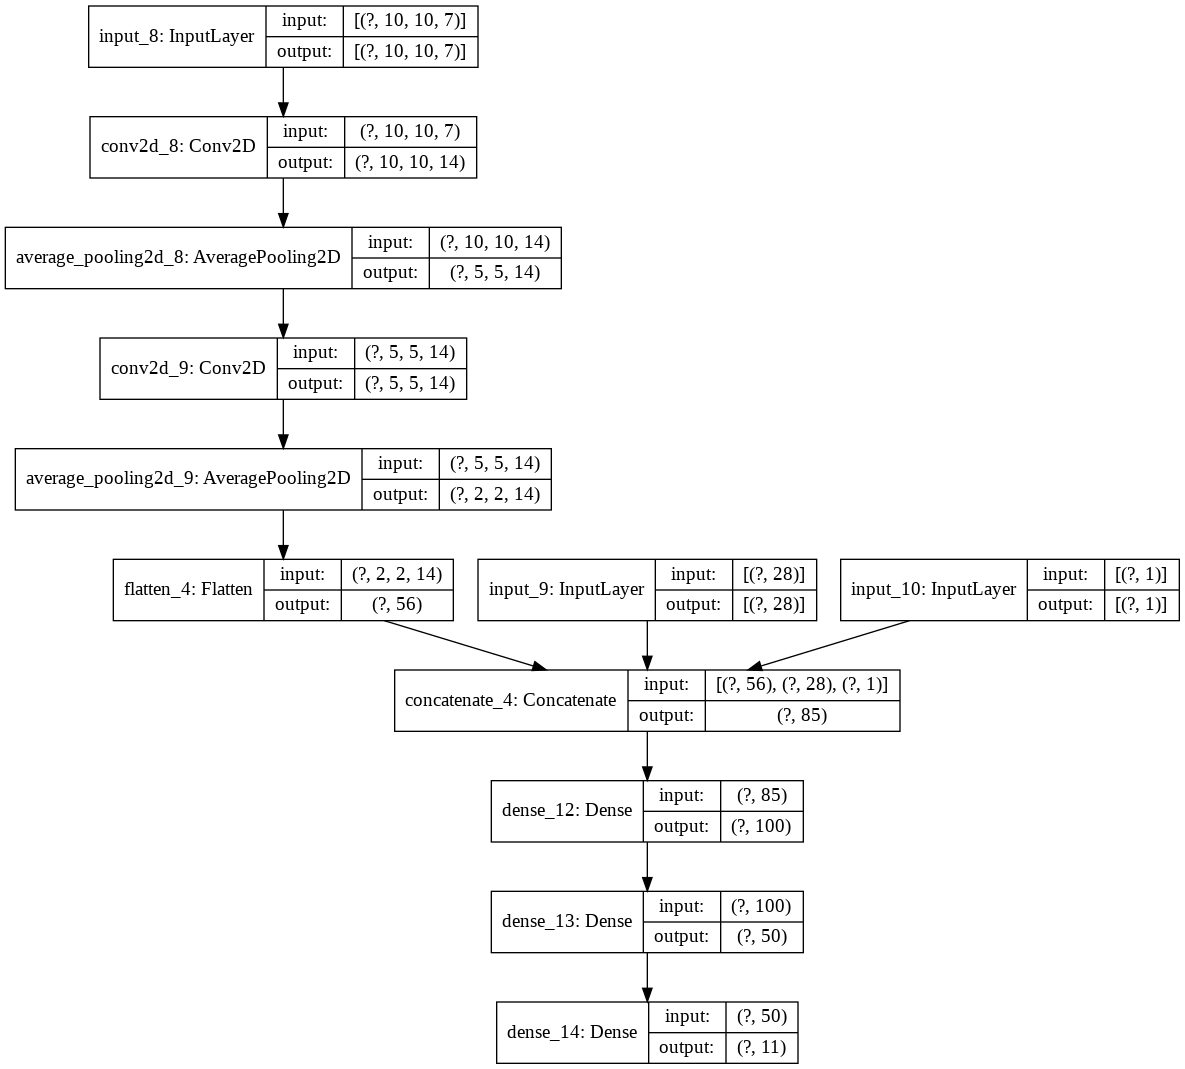

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

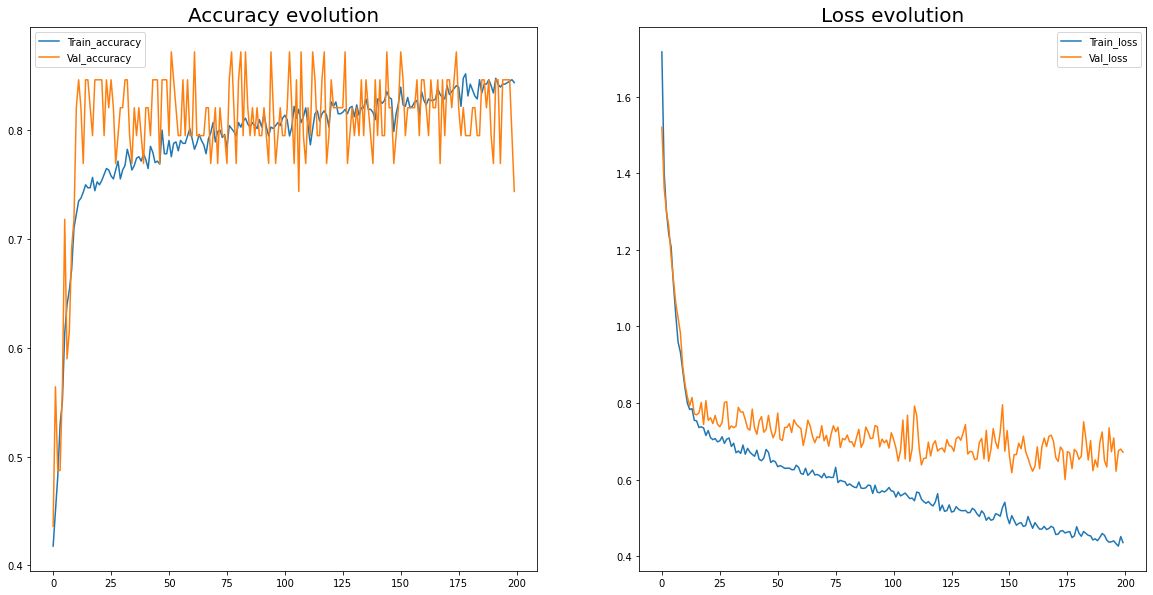

In [ ]:
def plot_history(model_history):
  val_accuracy = model_history.history['val_categorical_accuracy']
  train_accuracy = model_history.history['categorical_accuracy']
  val_loss = model_history.history['val_loss']
  train_loss = model_history.history['loss']

  fig, (a1, a2) = plt.subplots(1,2, figsize=(20,10))

  a1.set_title('Accuracy evolution', fontsize=20)
  a1.plot(train_accuracy, label='Train_accuracy')
  a1.plot(val_accuracy, label='Val_accuracy')
  a1.legend()

  a2.set_title('Loss evolution', fontsize=20)
  a2.plot(train_loss, label='Train_loss')
  a2.plot(val_loss, label='Val_loss')
  a2.legend()

  plt.show()

  return

plot_history(model_history)

array([[12,  0,  1,  0,  2],
       [ 1,  4,  0,  0,  0],
       [ 1,  0,  9,  0,  0],
       [ 4,  0,  0,  0,  1],
       [ 2,  0,  0,  0,  3]])

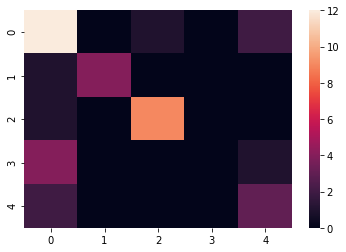

In [ ]:
from sklearn.metrics import confusion_matrix

y_proba_nnet = model.predict([images_val, meta_val, campaign_val])
y_pred = np.argmax(y_proba, axis=1)

model_conf_matrix = confusion_matrix(cultivos_val_encoded.flatten(), y_pred.flatten())

sns.heatmap(model_conf_matrix)
model_conf_matrix

### Convolutional Neural Network with two images per field
 
Objetivo: Evaluar la mejora en las métricas tomando dos imagenes por localización en momentos estratégicos del ciclo de cultivo. Se hipotetiza que agregar imagenes en puntos donde los cultivos están en etapas diferentes del cíclo de cultivo aportará información valiosa que mejore las métricas.
 
Input:
- 2 imágenes de 20x20 (200x200mts) con bandas RGB + Infrarojo Bajo + NDVI + SAVI + Indice de Humedad por cada localización (Las imágenes fueron seleccionadas de la primera quincena de enero y úlitma quincena de diciembre de la campaña correspondiente)
- Media y Desvío de los valores de las 14 bandas de cada imágen
- Campañia: 0 para 18/19, 1 para 19/20  
 
Features a predecir:
- Se tomaron para clasificar las 5 categorías de mayor frecuencia
 
Características del modelo:
- 3 Capas convolucionales
- 3 Capas Average pooling
- 3 Capas densas

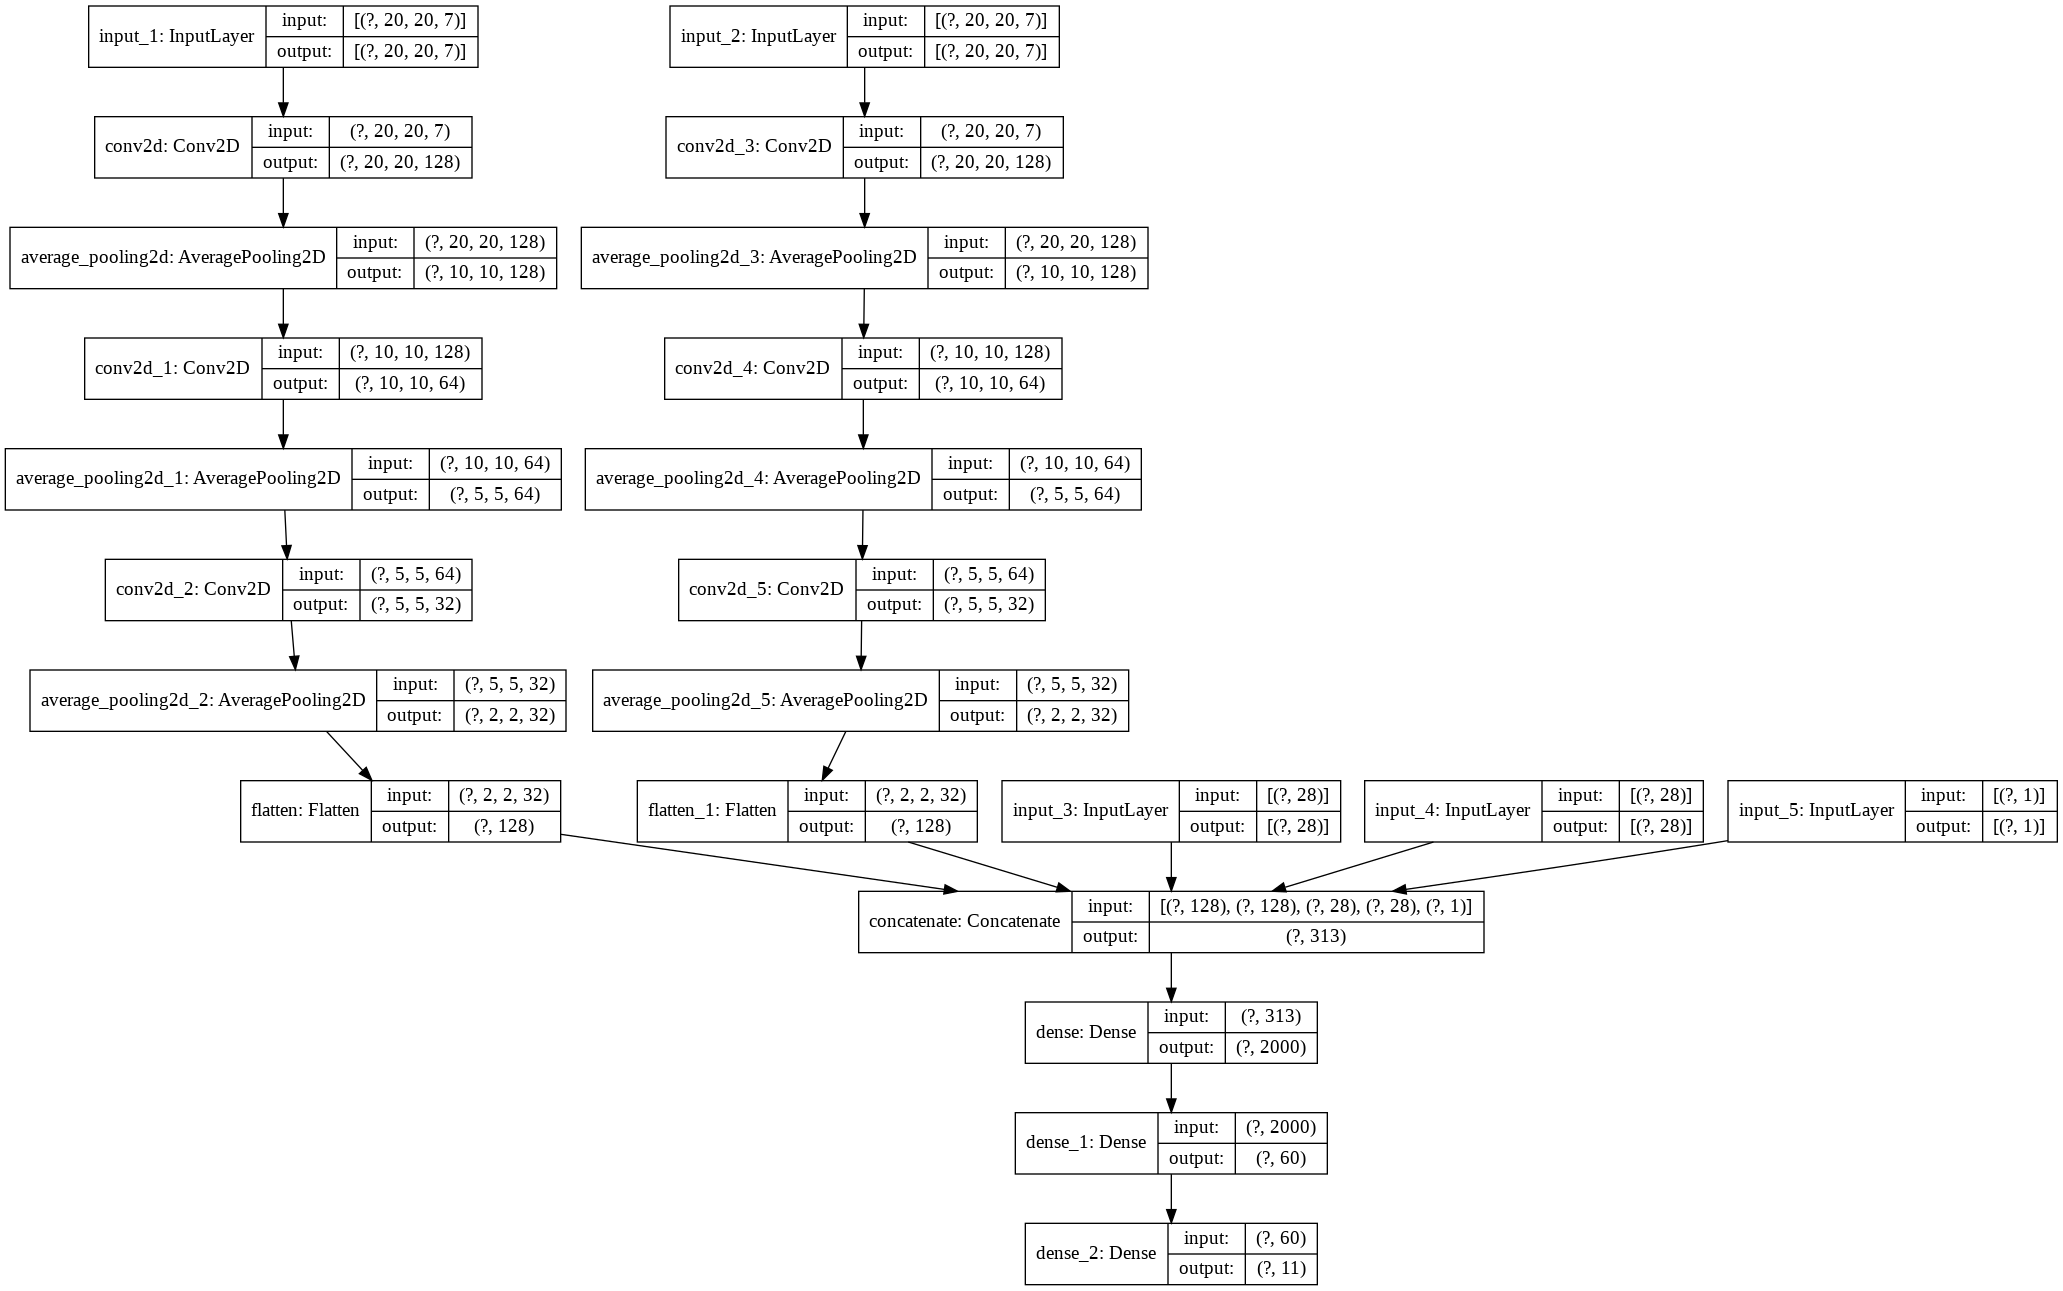

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
 
img1Input = tf.keras.Input(shape=(20,20,7))
img2Input = tf.keras.Input(shape=(20,20,7))
 
meta1Input = tf.keras.Input(shape=(28,))
meta2Input = tf.keras.Input(shape=(28,))
 
campaignInput = tf.keras.Input(shape=(1,))
 
## Convolutional NNet image 1
Conv11 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(img1Input)
Pool11 = tf.keras.layers.AveragePooling2D((2,2))(Conv11)
Conv21 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool11)
Pool21 = tf.keras.layers.AveragePooling2D((2,2))(Conv21)
Conv31 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool21)
Pool31 = tf.keras.layers.AveragePooling2D((2,2))(Conv31)
Flat11 = tf.keras.layers.Flatten()(Pool31)
 
## Convolutional NNet image 2
Conv12 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(img2Input)
Pool12 = tf.keras.layers.AveragePooling2D((2,2))(Conv12)
Conv22 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool12)
Pool22 = tf.keras.layers.AveragePooling2D((2,2))(Conv22)
Conv32 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool22)
Pool32 = tf.keras.layers.AveragePooling2D((2,2))(Conv32)
Flat12 = tf.keras.layers.Flatten()(Pool32)
 
 
ConcatInputs2 = tf.keras.layers.Concatenate()([Flat11, Flat12, meta1Input, meta2Input, campaignInput])
FC12 = tf.keras.layers.Dense(units=2000,activation='relu')(ConcatInputs2)
FC22 = tf.keras.layers.Dense(units=60,activation='relu')(FC12)
Output = tf.keras.layers.Dense(units=11,activation='softmax')(FC22)
 
model_twoimages = tf.keras.Model(inputs=[img1Input, img2Input, meta1Input, meta2Input, campaignInput], outputs=Output, name="LaRompeModel")
 
model_twoimages.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])
 
plot_model(model_twoimages, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_history = model_twoimages.fit(
                          [images_train, images_train_set2, meta_train, meta_train_set2, campaign_train.reshape(-1,1)], 
                          to_categorical(cultivos_train_encoded),
                          batch_size=50,
                          shuffle=True,
                          validation_data = ([images_val, images_val_set2, meta_val, meta_val_set2, campaign_val.reshape(-1,1)], to_categorical(cultivos_val_encoded)),
                          epochs=200)

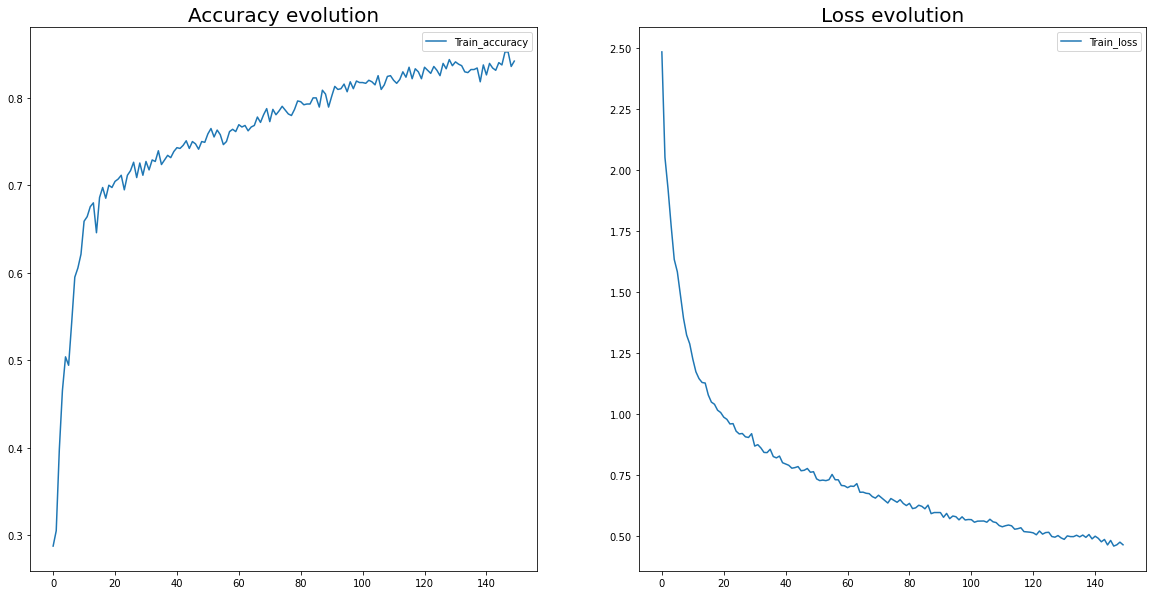

In [ ]:
plot_history(model_history)

### Convolutional Neural Network with with IMAGE AUGMENTATION
 
Objetivo: El desafío principal que identificamos es que el modelo prediga las categorías que tienen menor cantidad de  observaciones en el set de entrenamiento. Lograr la predicción exitosa de dichas categorías tendría un efecto muy positivo en la balanced accuracy, métrica elegida para la evaluación. Para alcanzar este objetivo, se inclyueron el resto de las categorías antes filtradas y se realizaron tecnicas de data augmentation para incrementar las probabilidades de que el modelo prediga correctamente las categorías poco frecuentes. 
Input:
- 2 imágenes de 20x20 (200x200mts) con bandas RGB + Infrarojo Bajo + NDVI + SAVI + Indice de Humedad por cada localización (Las imágenes fueron seleccionadas de la primera quincena de enero y úlitma quincena de diciembre de la campaña correspondiente)
- El dataset fue AUMENTADO con pares de imagenes de 20x20 (200x200mts) con bandas RGB + Infrarojo Bajo + NDVI + SAVI + Indice de Humedad por cada localización (Las imágenes fueron seleccionadas de la primera quincena de enero y úlitma quincena de diciembre de la campaña correspondiente) sólamente para las categorías de baja frecuencia
Media y Desvío de los valores de las 14 bandas de cada imágen 
Features a predecir:
- Se tomaron para clasificar las 26 categorías de mayor frecuencia
 
Características del modelo:
- 4 Capas convolucionales
- 3 Capas MAX pooling
- 3 Capas densas

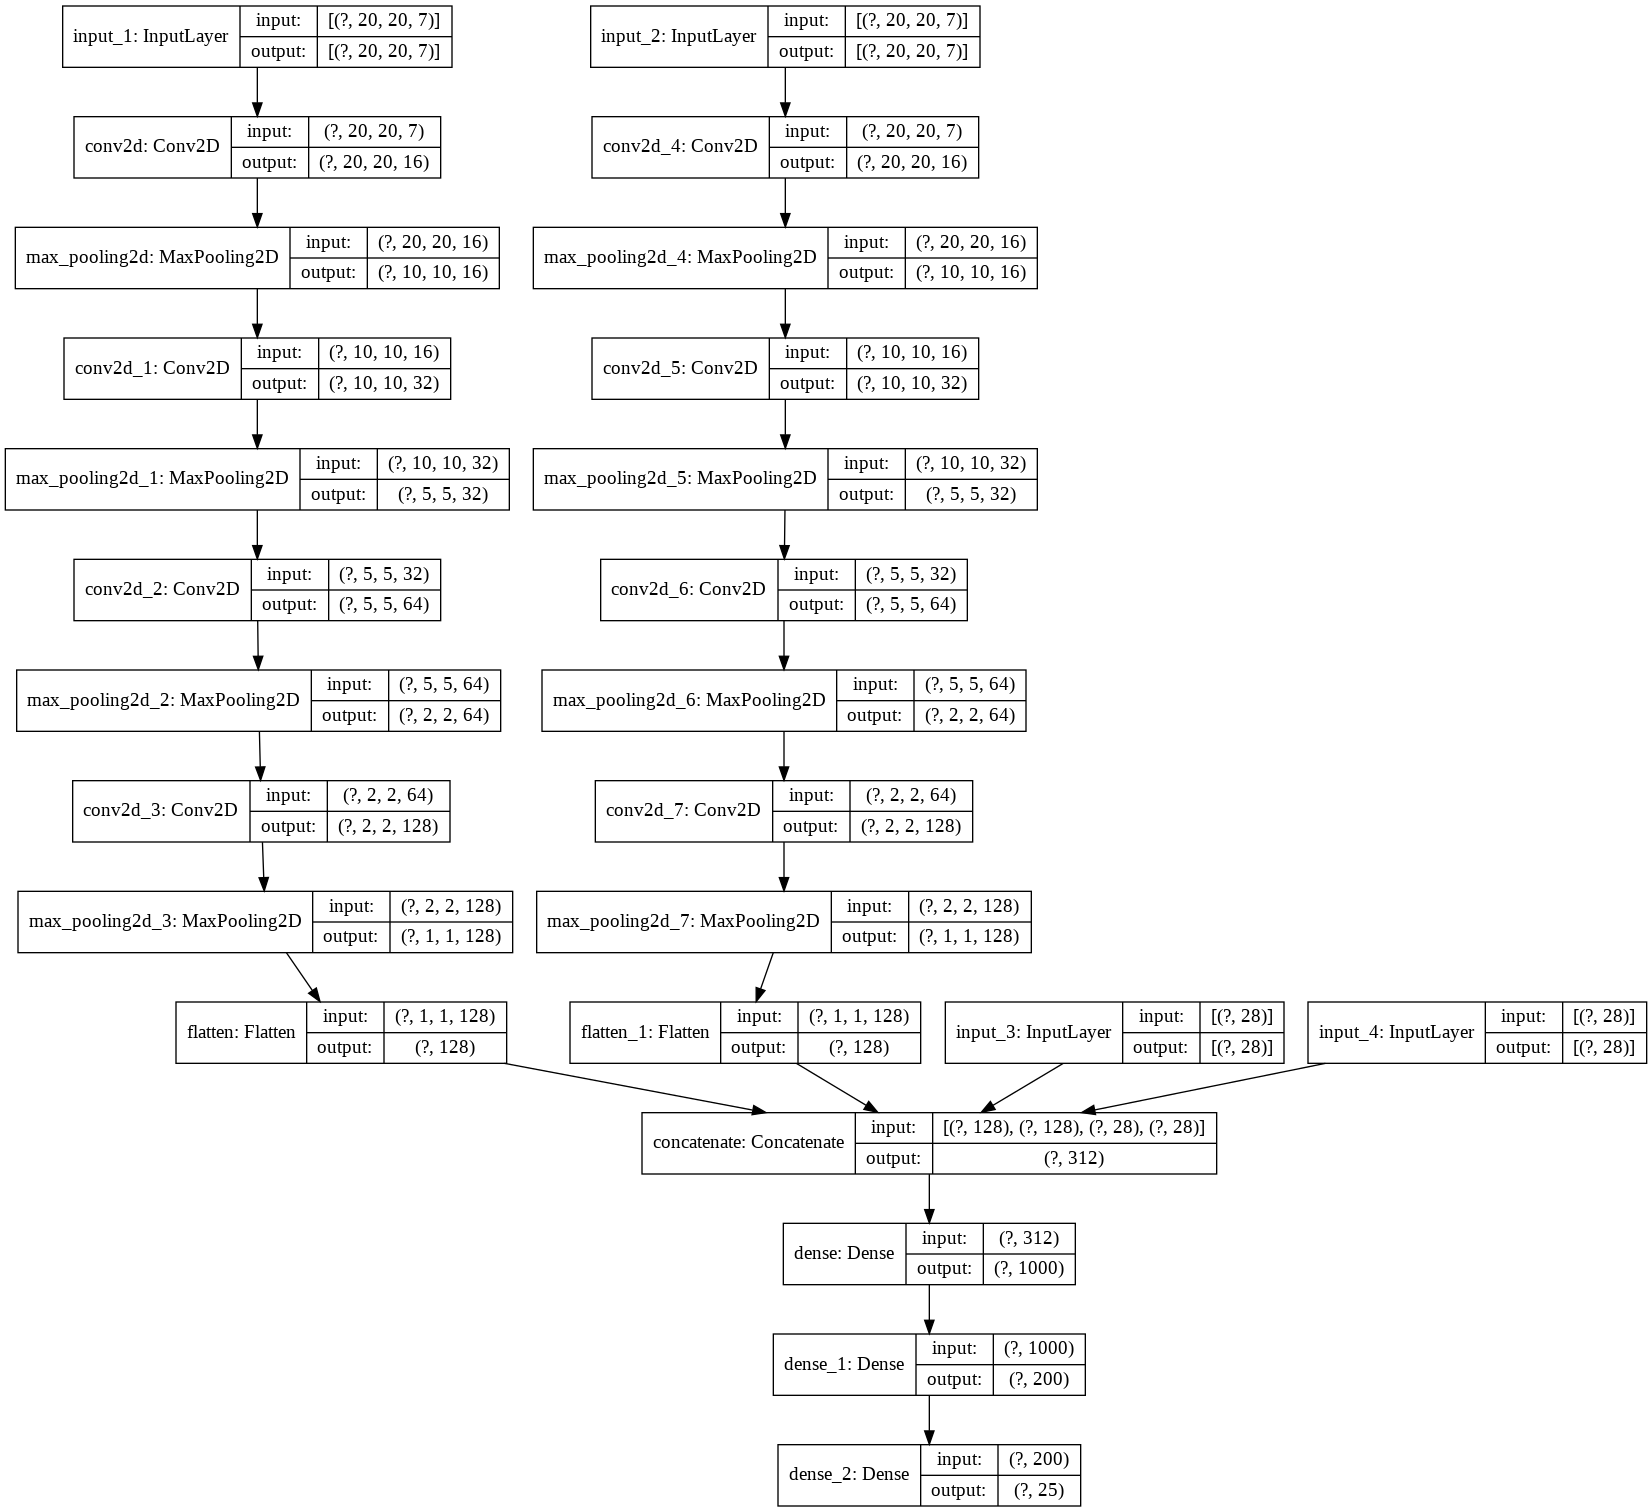

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

img1Input = tf.keras.Input(shape=(20,20,7))
img2Input = tf.keras.Input(shape=(20,20,7))

meta1Input = tf.keras.Input(shape=(28,))
meta2Input = tf.keras.Input(shape=(28,))

## Convolutional NNet image 1
Conv11 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=1,padding='same',activation='relu')(img1Input)
Pool11 = tf.keras.layers.MaxPooling2D((2,2))(Conv11)
Conv21 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool11)
Pool21 = tf.keras.layers.MaxPooling2D((2,2))(Conv21)
Conv31 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool21)
Pool31 = tf.keras.layers.MaxPooling2D((2,2))(Conv31)
Conv41 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool31)
Pool41 = tf.keras.layers.MaxPooling2D((2,2))(Conv41)
Flat11 = tf.keras.layers.Flatten()(Pool41)

## Convolutional NNet image 2
Conv12 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=1,padding='same',activation='relu')(img2Input)
Pool12 = tf.keras.layers.MaxPooling2D((2,2))(Conv12)
Conv22 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool12)
Pool22 = tf.keras.layers.MaxPooling2D((2,2))(Conv22)
Conv32 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool22)
Pool32 = tf.keras.layers.MaxPooling2D((2,2))(Conv32)
Conv42 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool32)
Pool42 = tf.keras.layers.MaxPooling2D((2,2))(Conv42)
Flat12 = tf.keras.layers.Flatten()(Pool42)


ConcatInputs2 = tf.keras.layers.Concatenate()([Flat11, Flat12, meta1Input, meta2Input])
FC12 = tf.keras.layers.Dense(units=1000,activation='relu')(ConcatInputs2)
FC22 = tf.keras.layers.Dense(units=200,activation='relu')(FC12)
Output = tf.keras.layers.Dense(units=25,activation='softmax')(FC22)

model_twoimages = tf.keras.Model(inputs=[img1Input, img2Input, meta1Input, meta2Input], outputs=Output, name="LaRompeModel")

model_twoimages.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])

plot_model(model_twoimages, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
train_full = [np.concatenate((images_train, images_val, images_aug), axis=0), 
              np.concatenate((images_train_set2, images_val_set2, images_aug2), axis=0),
              np.concatenate((meta_train, meta_val, meta_aug), axis=0),
              np.concatenate((meta_train_set2, meta_val_set2, meta_aug2), axis=0)]

cultivos_full = np.concatenate((cultivos_train_encoded, cultivos_val_encoded, cultivos_aug_encoded), axis=0)

model_history = model_twoimages.fit(
                          train_full, 
                          to_categorical(cultivos_full),
                          batch_size=50,
                          shuffle=True,
                          epochs=200)

Epoch 1/200
33/33 [==============================] - 0s 9ms/step - loss: 2.4608 - categorical_accuracy: 0.2460
Epoch 2/200
33/33 [==============================] - 0s 5ms/step - loss: 2.1449 - categorical_accuracy: 0.2930
Epoch 3/200
33/33 [==============================] - 0s 5ms/step - loss: 1.9817 - categorical_accuracy: 0.3828
Epoch 4/200
33/33 [==============================] - 0s 5ms/step - loss: 1.7917 - categorical_accuracy: 0.4713
Epoch 5/200
33/33 [==============================] - 0s 5ms/step - loss: 1.6165 - categorical_accuracy: 0.5293
Epoch 6/200
33/33 [==============================] - 0s 5ms/step - loss: 1.4873 - categorical_accuracy: 0.5580
Epoch 7/200
33/33 [==============================] - 0s 5ms/step - loss: 1.3762 - categorical_accuracy: 0.5873
Epoch 8/200
33/33 [==============================] - 0s 5ms/step - loss: 1.2829 - categorical_accuracy: 0.6129
Epoch 9/200
33/33 [==============================] - 0s 5ms/step - loss: 1.2352 - categorical_accuracy: 0.6294
E

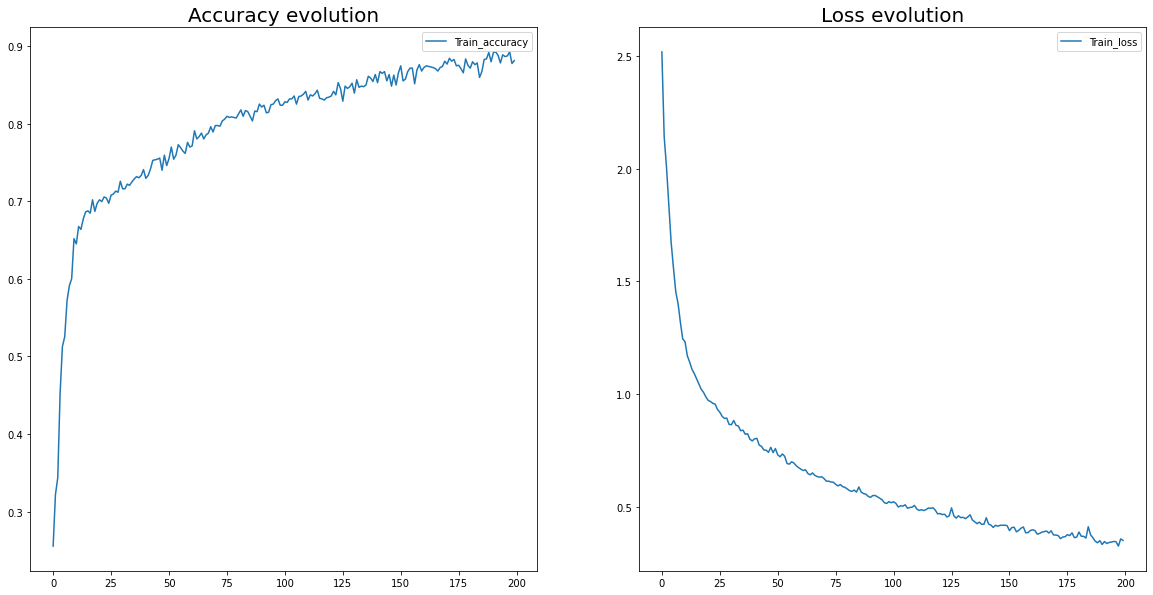

In [ ]:
plot_history(model_history)

In [ ]:
idx_image1 = np.argsort(general_ids_test.astype('int'))
idx_image2 = np.argsort(general_ids_test_set2.astype('int'))

prediction = model_twoimages.predict([images_test[idx_image1], images_test_set2[idx_image2], meta_test[idx_image1], meta_test_set2[idx_image2], campaign_test[idx_image1].reshape(-1,1)])

In [ ]:
output = np.argmax(prediction, axis=1).reshape(-1,1)
submit = np.concatenate((general_ids_test[idx_image1].astype('int').reshape(-1,1) ,output), axis=1)

In [ ]:
df = pd.DataFrame(submit)
df.to_csv(root_path+'submit.csv', index=False)

In [ ]:
np.unique(output, return_counts=True)

(array([ 1,  2,  3,  9, 10, 11, 23, 24]),
 array([273,  48, 133,  38,  51,   2,   3,   7]))

### Convolutional Neural Network with two images per field version 2
 
Objetivo: Al modelo anterior se le agrega la variable campañia, se optimizan hiperparámetros manualmente y NO SE TIENEN EN CUENTA LAS CATEGORIAS POCO FRECUENTES
Input:
- 2 imágenes de 20x20 (200x200mts) con bandas RGB + Infrarojo Bajo + NDVI + SAVI + Indice de Humedad por cada localización (Las imágenes fueron seleccionadas de la primera quincena de enero y úlitma quincena de diciembre de la campaña correspondiente)
- El dataset fue AUMENTADO con pares de imagenes de 20x20 (200x200mts) con bandas RGB + Infrarojo Bajo + NDVI + SAVI + Indice de Humedad por cada localización (Las imágenes fueron seleccionadas de la primera quincena de enero y úlitma quincena de diciembre de la campaña correspondiente) sólamente para las categorías de baja frecuencia
Media y Desvío de los valores de las 14 bandas de cada imágen 
Features a predecir:
- Se tomaron para clasificar las 11 categorías de mayor frecuencia
- Campañia: 0 para 18/19, 1 para 19/20   
Características del modelo:
- 4 Capas convolucionales
- 3 Capas MAX pooling
- 3 Capas densas

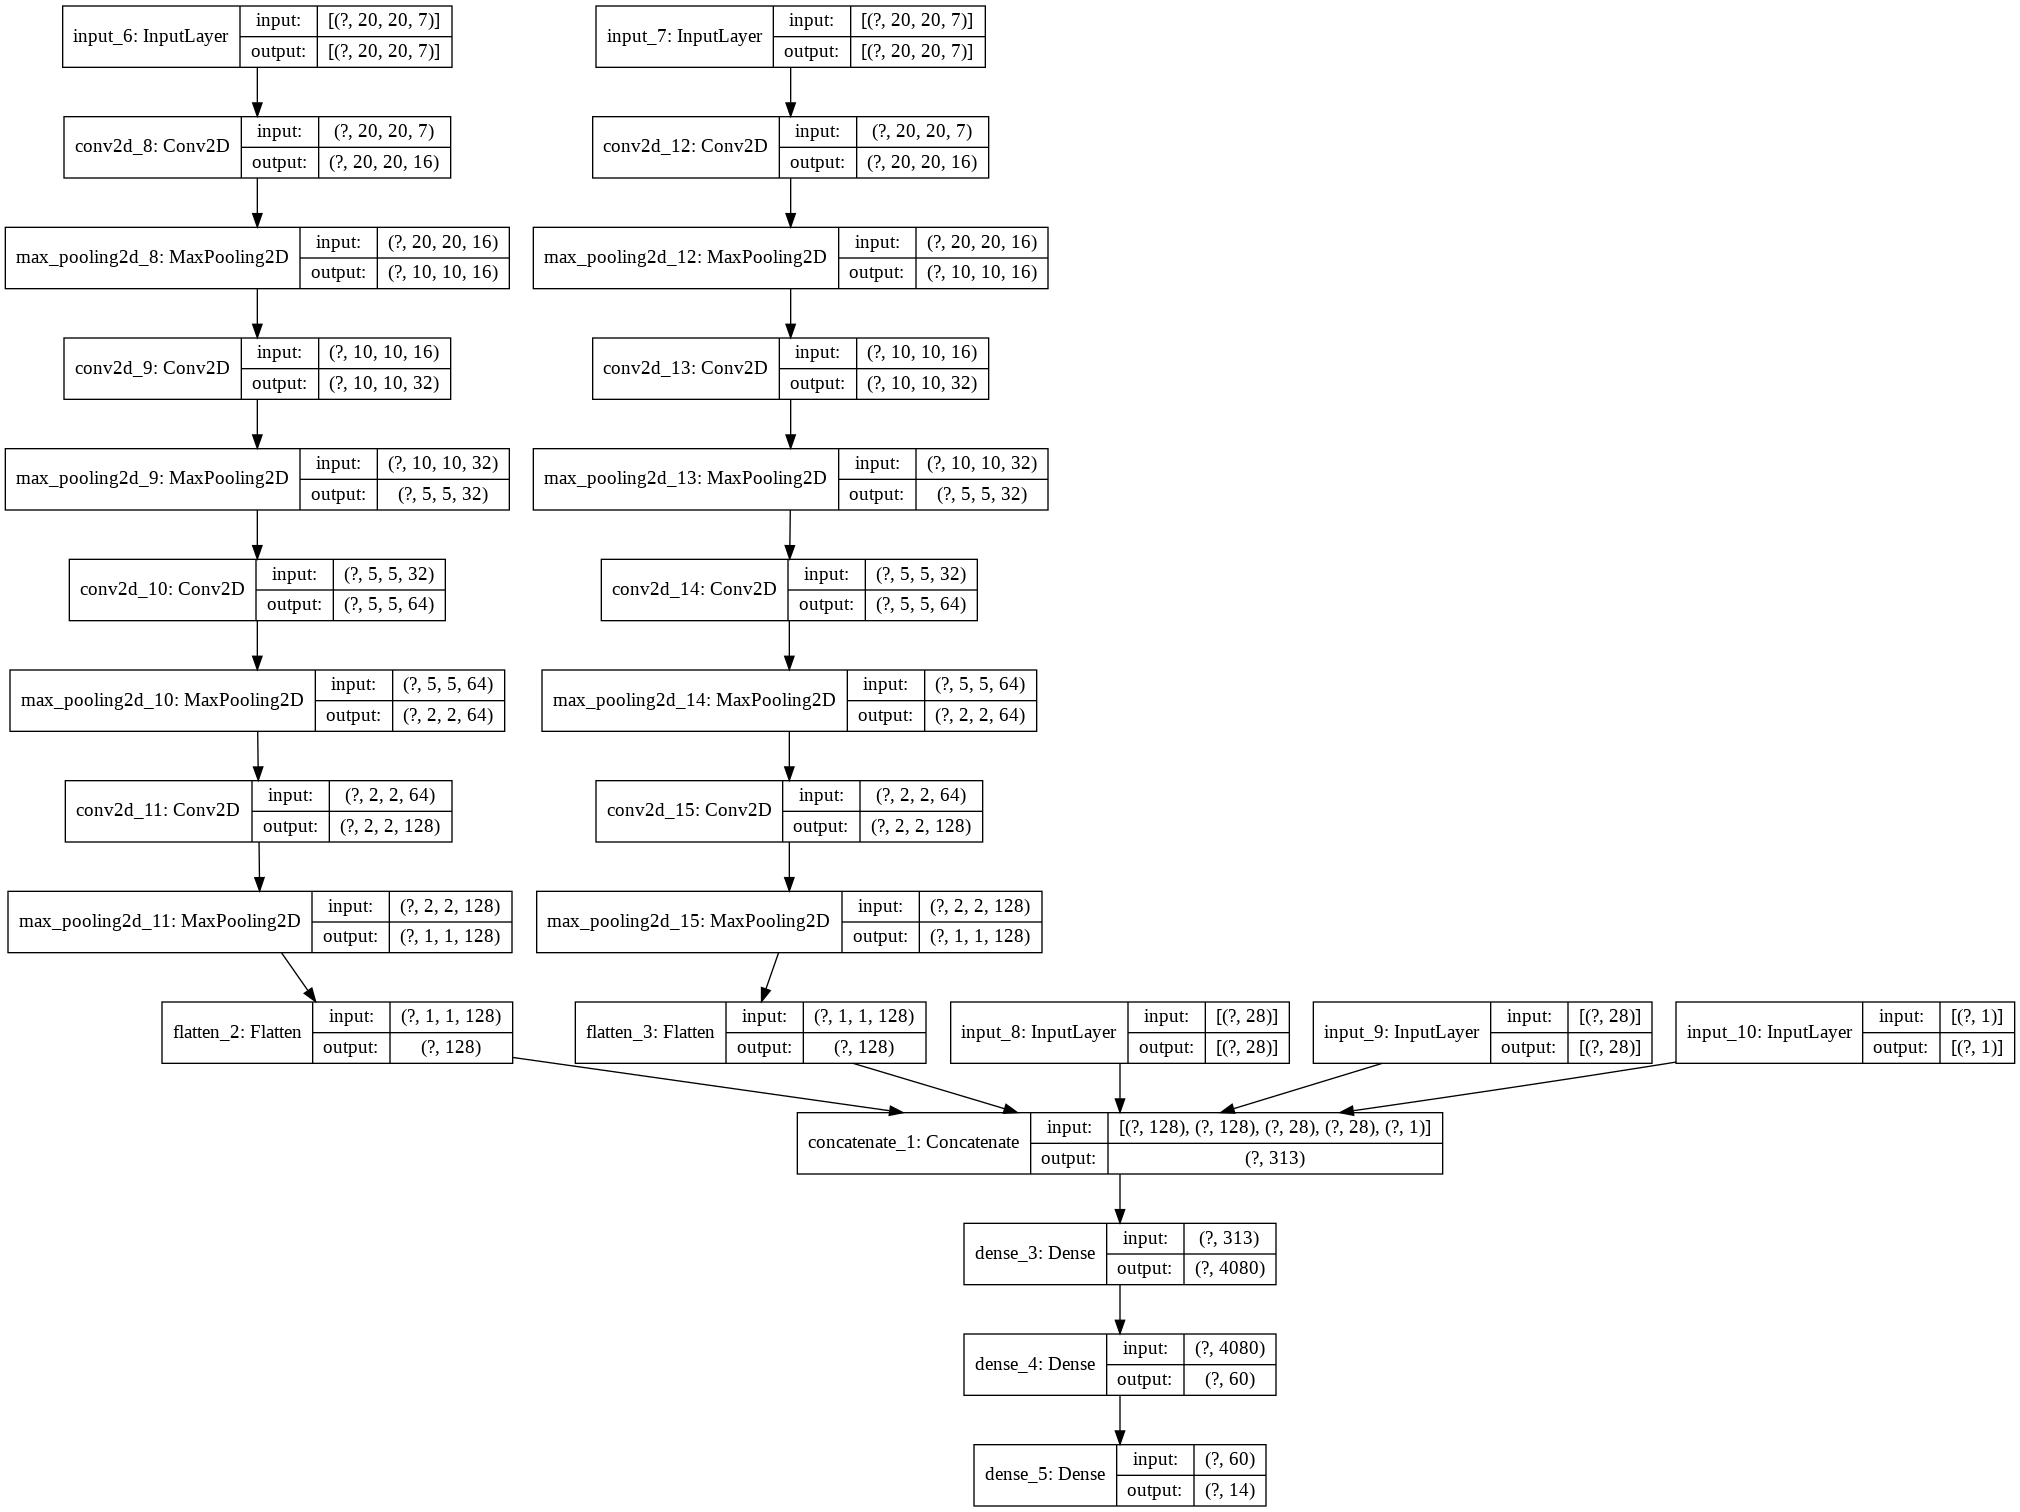

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
 
img1Input = tf.keras.Input(shape=(20,20,7))
img2Input = tf.keras.Input(shape=(20,20,7))
 
meta1Input = tf.keras.Input(shape=(28,))
meta2Input = tf.keras.Input(shape=(28,))
 
campaignInput = tf.keras.Input(shape=(1,))
 
## Convolutional NNet image 1
Conv11 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=1,padding='same',activation='relu')(img1Input)
Pool11 = tf.keras.layers.MaxPooling2D((2,2))(Conv11)
Conv21 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool11)
Pool21 = tf.keras.layers.MaxPooling2D((2,2))(Conv21)
Conv31 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool21)
Pool31 = tf.keras.layers.MaxPooling2D((2,2))(Conv31)
Conv41 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool31)
Pool41 = tf.keras.layers.MaxPooling2D((2,2))(Conv41)
Flat11 = tf.keras.layers.Flatten()(Pool41)
 
## Convolutional NNet image 2
Conv12 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=1,padding='same',activation='relu')(img2Input)
Pool12 = tf.keras.layers.MaxPooling2D((2,2))(Conv12)
Conv22 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool12)
Pool22 = tf.keras.layers.MaxPooling2D((2,2))(Conv22)
Conv32 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool22)
Pool32 = tf.keras.layers.MaxPooling2D((2,2))(Conv32)
Conv42 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool32)
Pool42 = tf.keras.layers.MaxPooling2D((2,2))(Conv42)
Flat12 = tf.keras.layers.Flatten()(Pool42)
 
 
ConcatInputs2 = tf.keras.layers.Concatenate()([Flat11, Flat12, meta1Input, meta2Input, campaignInput])
FC12 = tf.keras.layers.Dense(units=4080,activation='relu')(ConcatInputs2)
FC22 = tf.keras.layers.Dense(units=60,activation='relu')(FC12)
Output = tf.keras.layers.Dense(units=11,activation='softmax')(FC22)
 
model_twoimages = tf.keras.Model(inputs=[img1Input, img2Input, meta1Input, meta2Input, campaignInput], outputs=Output, name="LaRompeModel")
 
model_twoimages.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])
 
plot_model(model_twoimages, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
train_full = [np.concatenate((images_train, images_val), axis=0), 
              np.concatenate((images_train_set2, images_val_set2), axis=0),
              np.concatenate((meta_train, meta_val), axis=0),
              np.concatenate((meta_train_set2, meta_val_set2), axis=0),
              np.concatenate((campaign_train.reshape(-1,1),campaign_val.reshape(-1,1)), axis=0)]
train  = [images_train, images_train_set2, meta_train, meta_train_set2, campaign_train.reshape(-1,1)]
model_history = model_twoimages.fit(
                          train, 
                          to_categorical(cultivos_train_encoded),
                          batch_size=50,
                          shuffle=True,
                          epochs=200)

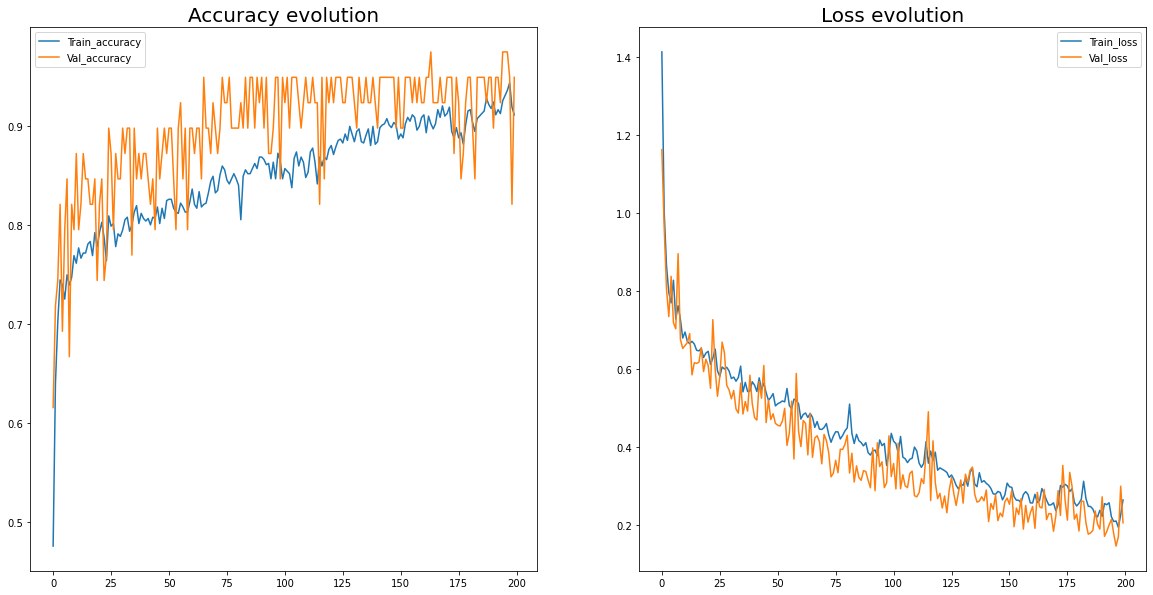

In [ ]:
plot_history(model_history)

### Convolutional Neural Network with two images per field version 3 - Full dataset
 
Objetivo: Al modelo anterior se le agregan las categorías POCO FRECUENTES
Input:
- 2 imágenes de 20x20 (200x200mts) con bandas RGB + Infrarojo Bajo + NDVI + SAVI + Indice de Humedad por cada localización (Las imágenes fueron seleccionadas de la primera quincena de enero y úlitma quincena de diciembre de la campaña correspondiente)
- El dataset fue AUMENTADO con pares de imagenes de 20x20 (200x200mts) con bandas RGB + Infrarojo Bajo + NDVI + SAVI + Indice de Humedad por cada localización (Las imágenes fueron seleccionadas de la primera quincena de enero y úlitma quincena de diciembre de la campaña correspondiente) sólamente para las categorías de baja frecuencia
Media y Desvío de los valores de las 14 bandas de cada imágen 
Features a predecir:
- Se tomaron para clasificar las 26 categorías de mayor frecuencia
- Campañia: 0 para 18/19, 1 para 19/20   
Características del modelo:
- 4 Capas convolucionales
- 3 Capas MAX pooling
- 3 Capas densas

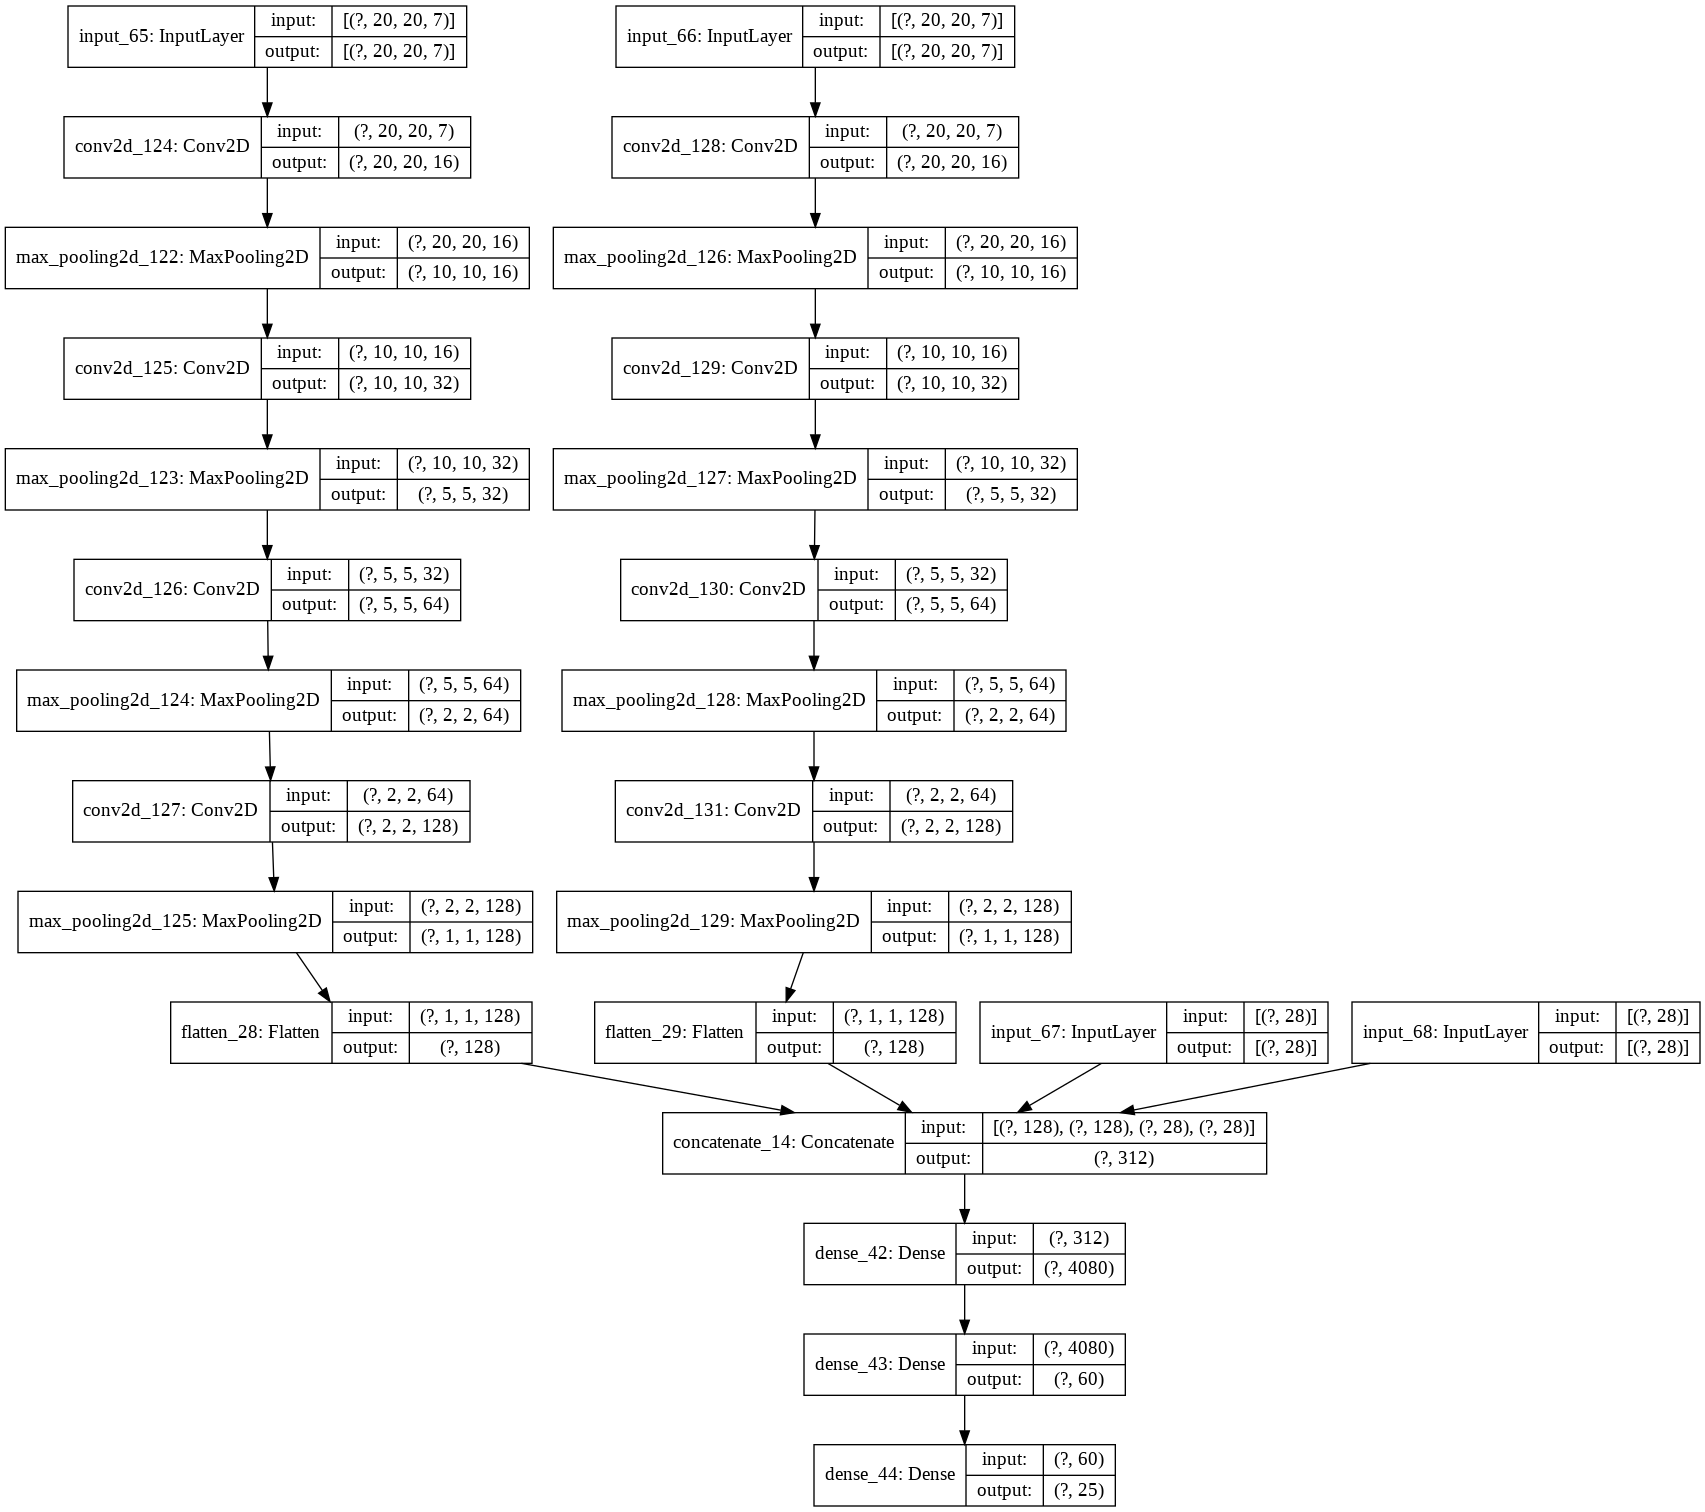

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
 
img1Input = tf.keras.Input(shape=(20,20,7))
img2Input = tf.keras.Input(shape=(20,20,7))
 
meta1Input = tf.keras.Input(shape=(28,))
meta2Input = tf.keras.Input(shape=(28,))
 
 
## Convolutional NNet image 1
Conv11 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=1,padding='same',activation='relu')(img1Input)
Pool11 = tf.keras.layers.MaxPooling2D((2,2))(Conv11)
Conv21 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool11)
Pool21 = tf.keras.layers.MaxPooling2D((2,2))(Conv21)
Conv31 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool21)
Pool31 = tf.keras.layers.MaxPooling2D((2,2))(Conv31)
Conv41 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool31)
Pool41 = tf.keras.layers.MaxPooling2D((2,2))(Conv41)
Flat11 = tf.keras.layers.Flatten()(Pool41)
 
## Convolutional NNet image 2
Conv12 = tf.keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=1,padding='same',activation='relu')(img2Input)
Pool12 = tf.keras.layers.MaxPooling2D((2,2))(Conv12)
Conv22 = tf.keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool12)
Pool22 = tf.keras.layers.MaxPooling2D((2,2))(Conv22)
Conv32 = tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool22)
Pool32 = tf.keras.layers.MaxPooling2D((2,2))(Conv32)
Conv42 = tf.keras.layers.Conv2D(filters=128,kernel_size=(2,2),strides=1,padding='same',activation='relu')(Pool32)
Pool42 = tf.keras.layers.MaxPooling2D((2,2))(Conv42)
Flat12 = tf.keras.layers.Flatten()(Pool42)
 
 
ConcatInputs2 = tf.keras.layers.Concatenate()([Flat11, Flat12, meta1Input, meta2Input])
FC12 = tf.keras.layers.Dense(units=4080,activation='relu')(ConcatInputs2)
FC22 = tf.keras.layers.Dense(units=60,activation='relu')(FC12)
Output = tf.keras.layers.Dense(units=25,activation='softmax')(FC22)
 
model_twoimages = tf.keras.Model(inputs=[img1Input, img2Input, meta1Input, meta2Input], outputs=Output, name="LaRompeModel")
 
model_twoimages.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['categorical_accuracy'])
 
plot_model(model_twoimages, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
train  = [images_train, images_train_set2, meta_train, meta_train_set2]
model_history = model_twoimages.fit(
                          train, 
                          to_categorical(cultivos_train_encoded),
                          batch_size=50,
                          shuffle=True, epochs=200)

Epoch 1/200
17/17 [==============================] - 0s 5ms/step - loss: 2.5624 - categorical_accuracy: 0.3731
Epoch 2/200
17/17 [==============================] - 0s 4ms/step - loss: 1.9424 - categorical_accuracy: 0.4042
Epoch 3/200
17/17 [==============================] - 0s 5ms/step - loss: 1.7051 - categorical_accuracy: 0.4341
Epoch 4/200
17/17 [==============================] - 0s 4ms/step - loss: 1.5955 - categorical_accuracy: 0.4726
Epoch 5/200
17/17 [==============================] - 0s 4ms/step - loss: 1.5129 - categorical_accuracy: 0.5162
Epoch 6/200
17/17 [==============================] - 0s 4ms/step - loss: 1.4354 - categorical_accuracy: 0.5522
Epoch 7/200
17/17 [==============================] - 0s 4ms/step - loss: 1.3774 - categorical_accuracy: 0.5560
Epoch 8/200
17/17 [==============================] - 0s 5ms/step - loss: 1.3130 - categorical_accuracy: 0.5871
Epoch 9/200
17/17 [==============================] - 0s 5ms/step - loss: 1.3054 - categorical_accuracy: 0.6045
E

In [ ]:
plot_history(model_history)

### Support Vector Machine

Objetivo: Experimentar con modelos alternativos a redes neuronales. En particular SVC. Evaluar si las métricas arrojadas son comparables con los modelos anteriores.
 
Input:
- Media y Desvío de los valores de las 14 bandas de cada imágen
 
Features a predecir:
- Se tomaron para clasificar las 5 categorías de mayor frecuencia
 
Características del modelo:
- SVC, con categorías balanceadas

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
scaler.fit(meta_train)
 
 
svc_model = SVC(class_weight='balanced', probability=True)
 
svc_model.fit(scaler.transform(meta_train), cultivos_train_encoded)
 
y_pred = svc_model.predict(scaler.transform(meta_val))
y_proba_svc = svc_model.predict_proba(scaler.transform(meta_val))
 
confusion_matrix(cultivos_val_encoded, y_pred)
 
 
## Pseudo ensemble
 
y_proba_artificial = y_proba_nnet
y_proba_artificial[:,[1,2,3,9,10]] = y_proba_nnet[:,[1,2,3,9,10]] #+ y_proba_svc
 
y_artificial = np.argmax(y_proba_artificial, axis=1)
confusion_matrix(cultivos_val_encoded.flatten(), y_artificial.flatten())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[13,  0,  0,  0,  2],
       [ 1,  4,  0,  0,  0],
       [ 2,  0,  8,  0,  0],
       [ 5,  0,  0,  0,  0],
       [ 3,  0,  1,  0,  1]])

In [ ]:
print(np.unique(y_artificial))
print(np.unique(cultivos_val_encoded))

[0 1 2 3 9]
[ 1  2  3  9 10]


### Modelos combinados: ConvNet + Tradicionales

Se realizaron pruebas donde se combinan las predicciones de las redes convolucionales con métodos tradicionales de machine learning entrenados sobre los datos estadísticos calculados (media y desviación estándar de los canales). 


Los modelos se entrenan en paralelo a las redes y con con ellos se utiliza el método **predict_proba** sobre el dataset de test, para luego hacer una suma ponderada con las predicciones de las redes neuronales, que será el output final combinado. 

Los resultados no fueron buenos, se documenta código que muestra el trabajo realizado.


In [ ]:
# Concat de metadata tanto en train como test
train_clasico = np.vstack([meta_train,meta_train_set2])
test_clasico = np.vstack([meta_test,meta_test_set2]) 

#MinMaxScaler
calibrador = preprocessing.MinMaxScaler() 
calibrador.fit(train_clasico) 

# Transforma train y test
x_train_calib = calibrador.fit_transform(train_clasico)
x_test_calib = calibrador.transform(test_clasico)

In [ ]:
# Una prediccion de una ConvNet sobre el dataset entero
# Se usan estas mismas predicciones para combinar con diferentes modelos
prediction = convnet_prediction.copy() 

#### Regresión logística

In [ ]:
logreg = linear_model.LogisticRegression() 
logreg.fit(x_train_calib,y_train)
y_logreg = logreg.predict_proba(x_test_calib)

In [ ]:
# Prediction es el output de la softmax de una ConvNet
# Los pesos fueron variados, pero los resultados nunca fueron satisfactorios
nn_logreg_prediction = prediction * 0.5 + y_logreg * 0.5
y_pred = np.argmax(nn_logreg_prediction)

#### Support Vector Classifier

In [ ]:
svc = svm.SVC()
svc.fit(x_train_calib,y_train)
y_svc = svc.predict_proba(x_test_calib)

In [ ]:
# Prediction es el output de la softmax de una ConvNet
# Los pesos fueron variados, pero los resultados nunca fueron satisfactorios
convnet_svc_prediction = prediction * 0.5 + y_svc * 0.5
y_pred = np.argmax(convnet_svc_prediction)

#### RandomForestClassifier

In [ ]:
rfc = ensemble.RandomForestClassifier(n_estimators=100,criterion='gini')
rfc.fit(x_train_calib,y_train)
y_rfc = rfc.predict_proba(x_test_calib)

In [ ]:
# Prediction es el output de la softmax de una ConvNet
# Los pesos fueron variados, pero los resultados nunca fueron satisfactorios
convnet_rfc_prediction = prediction * 0.5 + y_rfc * 0.5
y_pred = np.argmax(convnet_rfc_prediction)

### Modelo con pesos

Dado que el dataset tiene desbalance de clases, con algunas clases mucho menos representadas que otras, los modelos entrenados encuentran dificultad a la hora predecir algunas de ellas o directamente nunca las predicen. 

Sumado al trabajo realizado de **data augmentation**, se realizaron pruebas para incorparar **pesos** a las clases, de manera que el error asociado a una mala predicción en el entrenamiento tenga un mayor impacto en la actualización de los pesos. 

La implementación de `tf.keras` no tiene la posibilidad de utilizar un diccionario de tipo `{clase: peso}`, por lo que se calcula un nuevo vector `wtrain` de pesos asociados a cada muestra de entrenamiento, según su clase.

Para hacerlo se utiliza `compute_class_weight` de `sklearn.utils.class_weight`, que calcula los pesos asociados a cada clasepara construir un diccionario que permite mapear `Y` de las salidas en pesos.  

La función requiere previamente tener todas las clases codificadas en valores enteros consecutivos, que fue realizado con `LabelEncoder`, también de `sklearn`. 

`LabelEncoder` toma las etiquetas con sus valores originales y las mapea a valores en $[0, C-1]$. Este Encoder luego se utilizar para remapear las predicciones de $[0, C-1]$ a las etiquetas de clases originales para poder evaluar train en la página de la competencia. 

Se hizo una **primera prueba**, utilizando los pesos generados de manera `'balanced'` que calcula el peso como $w_{c}=\frac{Nsamples}{Nclasses * np.bincount(y)}$. Esto generó resultados bastante malos ya que asignaba pesos extremadamente grandes a esas pocas clases subrepresentadas, perdiendo mucho en la calidad de predicción de las clases que antes podían identificar mejor. 

Para contrarestar este efecto, a la hora asignar los pesos se introdujo un threshold de manera que el pesos que se le asigna a una muestra es $max \{W_{asignado},5\}$, con $W_{asignado}$ siendo los pesos calculados por `sklearn`. El valor de $5$ se encontró de manera empírica, probando diferentes valores y comparando la cantidad de clases que predecía el modelo y el score obtenido en test. 


In [ ]:
from sklearn.preprocessing import LabelEncoder # Carga función LabelEncoder

le = preprocessing.LabelEncoder() #Crea LabelEncoder
le.fit(y_aug) # Fit del Encoder a los datos de entrenamiento (y_augmented)
y_aug_enc = le.transform(y_aug) # Transformación de los datos


from sklearn.utils.class_weight import compute_class_weight # Carga función 
weights = compute_class_weight(class_weight="balanced",classes=y_enc, y=le.transform(y_train)) # Genera pesos
wdict = {i: weights[i] for i in range(0,14,1)} # Genera diccionario {clase: peso}
wtrain = np.array([np.max([wdict.get(x),5]) for x in y_aug_enc]) # Genera vector de pesos sobre las muestras de train

El vector `wtrain` queda como un vector de pesos de las muestras con una dimensión de $N_{train}\times 1 $ que puede incluirse en el `fit` de las redes con `keras`.

Las pruebas que se realizaron fueron satisfactorias, aunque el modelo que mejor performance tuvo al realizar el submit a la competencia fue uno entrenado sin pesos. 

# Conclusiones

### Conclusiones generales

La **construcción del dataset** fue un desafío importante por ser la primera vez que trabajamos con imágenes satélitales. 

Fue un proceso de mucho aprendizaje donde nos familiarizamos con la información disponible por los diferentes proveedores de imágenes satelitales, el funcionamiento de las API, conceptos de GIS y particularidades para industria agrícola. 

Un punto muy importante para la mejora del scoring fue el **descargar más imágenes**. La muestra es relativamente pequeña y teniendo una única imágen por punto los clasificadores entrenados no eran suficientemente buenos. Al aumentar la cantidad de imágenes por punto incorporamos de alguna manera la dimensión del tiempo (ya que las tomamos en diferentes momentos) y esto fue el primer salto de calidad en los modelos, pasando de scores en el rango de $[0.15, 0.25]$ a $[0.30, 0.40]$.

El **preprocesamiento** también jugó un papel muy importante por la naturaleza desbalanceada del dataset. La métrica seleccionada por los organizadores de la competencia obligaba a los participantes a tener en cuenta las clases sub-representadas: ser muy bueno detectando las clases con más samples no era suficiente para tener un buen score. Esto nos llevó a utilizar técnicas adicionales como **data augmentation** y **pesos**, que pertmitieron que los scores obtenidos mejoren. Estas incorporaciones significaron el siguiente salto en el scoring obtenido, logrando construir clasificadores que obtengan consistentemente scores superiores a $.45$ y un máximo de $0.53001$.

En cuanto a los **modelos** se trabajó principalmente con **Keras** y su **API funcional**, con los que se obtuvieron los mejores resultados.
Modelos tradicionales implementados en **sklearn** también fueron probados, pero los resultados no fueron alentadores.  

## Oportunidades de mejora

Luego del trabajo realizado se identifican a continuación algunos aspectos que podrían ayudar a mejorar la performance de los modelos:

* **Data Augmentation** sobre las clases menos pobladas: varias de las clases contaban con pocas instancias de observación tanto en el set de entrenamiento como en el de testeo. Mediante Data Augmentation conseguimos reconocer más clases, pero no todas. Entendemos que una opción probable sería tomar más muestras en ubicaciones cercanas a cada localización dada por el dataset. Otra opción sería conseguir muestras de esos cultivos pero de otros satélites, pero con la desventaja de que la recolección y preprocesamiento de imágenes pueda ser diferente.
* Uso de **información de contexto**: cómo vimos en la sección de Data Analysis, tanto la elevación(correlación lineal con la salida), como la distancia a un punto central podría aportar información al modelo.
* **Combinar** información de diversos **satélites**: similar a lo argumentado respecto al Data Augmentation, otros satélites disponibles podrían agregar nueva data para aumentar el train set y mejorar las predicciones. 
* Técnicas de **reducción de dimensionalidad**: un objetivo sería reducir la dimensionalidad para quedarnos con la menor cantidad de features que representen la mayor parte de la varianza de datos o utilizar esas mismas para agregarlas a las ya existentes.
* Utilizar datasets de **otras fuentes**: Por ejemplo, el servicio de agricultura de EEUU tiene una API donde mapea el territorio de ese país con labels de cultivos. En este caso deberíamos considerar las bandas de frecuencia que recolecta y el preprocesamiento para entender la posible combinación con las imágenes ya obtenidas.
* Mejorar la **temporalidad** del dataset: Tomar más muestras a lo largo del tiempo y generar features que incorporen variaciones temporales. Así también lograr dar solución a la falta de información respecto a la estación en la cual fueron tomadas las verdades de campo.
